# Answer the F Question

## 1. 导入所需要的库

In [1]:
# 基本库
import os
import datetime
import time
import math

# 数据读取
import pandas as pd
import numpy as np

# 可视化
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
from matplotlib import cm
import seaborn as sns

# 操作Excel表格
# 只用读取即可。
import xlrd

# 地图显示
from pyecharts.charts import Bar
import pandas as pd
from pyecharts.charts import Map, Geo
from pyecharts import options as opts

# 用于调用地图API
import json
import requests
import geopy
from geopy.geocoders import Nominatim

import tensorflow as tf
import networkx as nx
import dgl
from dgl.nn.tensorflow import GraphConv
from sklearn.cluster import KMeans

## 2 定义公共函数

输出信息

In [2]:
def DisplayStartInfo():
    """
    :description: 显示开始时间。
    :param None {type: None}: 
    :return startTime {type: datetime.datetime}{count: 1}: 返回当前时间。
    """
    print("-------------------------Start-------------------------")
    startTime = datetime.datetime.now()
    print(startTime.strftime('%Y-%m-%d %H:%M:%S'))
    return startTime


def DisplayCompletedInfo(startTime=datetime.datetime.now(), isDisplayTimeConsumed=False):
    """
    :description: 显示结束时间信息。
    :param startTime {type: datetime.datetime} {default: datetime.datetime.now()}:: 显示开始时间。default值搭配着isDisplayTimeConsumed=False一起使用，这个时候可以不输出消耗时间。
    :param isDisplayTimeConsumed {type: bool} {default: False}: 是否显示消耗的时间，默认值不显示。
    :return None {count: 0}: 
    """
    if isDisplayTimeConsumed==True:
        print('Time consumed:', str(datetime.datetime.now() - startTime).split('.')[0])
    print("Completed at " + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ".\n")
    print("-------------------------Completed-------------------------")

def DisplaySeparator():
    print("---------------------------------------------------------\n")

In [3]:
DisplayCompletedInfo()

Completed at 2022-10-14 13:17:19.

-------------------------Completed-------------------------


可视化设置

In [4]:
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [5]:
# 设置字体
# STFANGSO.TTF字体需要拷贝。在没有STFANGSO.TTF的情况下，可以使用windows默认字体simsun.ttc。
myFont = fm.FontProperties(fname='c:\windows\Fonts\STFANGSO.TTF')
# myFont = fm.FontProperties(fname='c:\windows\Fonts\simsun.ttc')

# 设置图像大小
figSizeNormal = (5, 3.09)
figSizeHuge = (8, 8)


def setRainbowColors(valueList):
    """_summary_ 设置饼图的彩虹色

    Args:
        valueList (list): 输入值的列表。

    Returns:
        list: 彩虹色的列表。
    """
    return cm.rainbow_r(np.arange(len(valueList))/len(valueList))

def make_autopct(values_list):
    def my_autopct(pct):
        total = sum(values_list)
        val = int(round(pct*total)/100.0)
        return '{p:1.1f}% ({v:d}人)'.format(p=pct, v=val)
    return my_autopct

# 首先计算百分比
def calculatePercentage(inputList):
    percentageList = []
    total = sum(inputList)
    for temp in inputList:
        percentageList.append(round((temp/total * 100.0),1))
    return percentageList

生成单个柱状图

In [6]:

def drawingSingBar(data_df, title, x_column_name, y_column_name, 
                   xlabel, ylabel, label_name, path, imageSize=(6, 6), ShowEnable=True):
    """_summary_ 绘制单个柱状图。

    Args:
        data_df (Pandas.Dateframe): 包含显示信息的Dataframe数据集。
        title (string): 图的名称。
        x_column_name (string): x轴在数据集中的列名。
        y_column_name (string): y轴在数据集中的列名。
        xlabel (string): x轴标签名。
        ylabel (string): y轴标签名。
        label_name (string): 图例的名称。
        path (string): 保存路径。
        imageSize (tuple, optional): 图片整体大小. Defaults to (6, 6).
        ShowEnable (boolean, optional): 图片是否显示在jupyter中。
                                        如果false就只保存，不展示结果。Defaults to True.
    """
    x = data_df[x_column_name]
    y = data_df[y_column_name]
    fig = plt.figure(figsize=imageSize, dpi=80)
    ax = fig.add_subplot(111)
    ax.plot(x, y, label=label_name)
    tick_spacing = 180
    plt.xticks(rotation=45)
    plt.xlabel(xlabel, fontproperties=myFont)
    plt.ylabel(ylabel, fontproperties=myFont)
    plt.title(title)
    plt.grid(alpha=0.4)
    plt.legend(prop=myFont, loc='upper left')
    plt.savefig(path)
    if ShowEnable == True:
        plt.show()
    plt.clf()
    plt.close()

## 3. 数据读取及数据预处理

将所有excel中的数据按日期读取出来，并统一建议按种类分布的表。

## 3.1 文件批量改名

|编号|数据名称|重命名英文名称|说明|
|---|---|---|---|
|1|附件1：长春市COVID-19疫情期间病毒感染人数数据-新增本土感染者|1nlip|1New Local Infected Persons|
|2|附件1：长春市COVID-19疫情期间病毒感染人数数据-新增无症状感染者|1nai|1New Asymptomatic Infections|
|3|附表2：长春市9个区隔离人口数量与生活物资投放点数量|2pndpl|2Population and Number of Distribution Points of LivingMaterials|
|4|交通路口节点数据|3tind|Traffic intersection node data|
|5|交通路口路线数据|3tird|Traffic intersection route data|
|6|各区主要小区数据|3dmced|Data of main communities in each district|
|7|附件3/1.XX月XX日长春市重点民生商品供应情况表(0316模板）|31sklc|Supply of Key Livelihood Commodities|
|8|附件3/2.长春市生活物资保障体系基本情况表|32bilmss|Basic Information of Living Material Support System|
|9|附件3/3.XX月XX日长春市主要粮油副食品零售价格监测表|33rpmconsf|Monitoring Table for Retail Price of Major Cereals, Oils and Non staple Foods|
|10|附件3/4.XX月XX日长春市重点蔬菜零售价格监测表|34rpkv|Monitoring Table for Retail Price of Key Vegetables|
|11|附件3/5.点调重点企业主要生活必需品价格情况表|35pmnke|Price of main necessities of key enterprises|
|12|附件3/|||
|13||||
|14||||
|15||||
|16||||
|||||
|||||
|||||

1. “4月29日”是一个关键节点，同名的文件夹有2个数据。一份是正常的日报；另一份是复工情况报告，这一份重名为“4月29日fg”。
2. 一共有352个xls/xlsx文件。
3. 重点民生商品供应情况表共计57个。
4. 重点民生商品供应情况表 中定义列数有28列。定义行数为65行（也就是65天排除了4月29日fg这个文件夹）。
   1. 列名
      |编号|名称|英文|说明|
      |---|---|---|---|
      |1|粮食总储备量|gtr|Total grain reserves|
      |2|粮食政府储备|ggr|Grain government reserves|
      |3|粮食重点企业库存|gike|Inventory of key grain enterprises可以为空|
      |4|粮食日出库量|gdo|Daily grain output|
      |5|粮食日进货量|gdp|Daily grain purchase|
      |6|粮食保障天数|gsd|Grain security days|
      |7|粮食储备标准|grs|Grain reserve standard|
      |8|食用油总储备量|otr|Oil|
      |9|食用油政府储备|ogr||
      |10|食用油重点企业库存|oike|可以为空|
      |11|食用油日出库量|odo||
      |12|食用油日进货量|odp||
      |13|食用油保障天数|osd||
      |14|食用油储备标准|ors||
      |15|猪肉总储备量|ptr|pork|
      |16|猪肉政府储备|pgr||
      |17|猪肉重点企业库存|pike|可以为空|
      |18|猪肉日出库量|pdo||
      |19|猪肉日进货量|pdp||
      |20|猪肉保障天数|psd||
      |21|猪肉储备标准|prs||
      |22|蔬菜总储备量|vtr|vegatable|
      |23|蔬菜政府储备|vgr||
      |24|蔬菜重点企业库存|vike|可以为空|
      |25|蔬菜日出库量|vdo||
      |26|蔬菜日进货量|vdp||
      |27|蔬菜保障天数|vsd||
      |28|蔬菜储备标准|vrs||
   2. 行名：从'3月18日'开始，到'5月23日'结束。共65天，注意数据5月21日和5月22日缺失。。


生成列名列表。

In [7]:
sklcColoumnNameList = ['gtr', 'ggr', 'gike', 'gdo', 'gdp', 'gsd', 'grs', 
                       'otr', 'ogr', 'oike', 'odo', 'odp', 'osd', 'ors', 
                       'ptr', 'pgr', 'pike', 'pdo', 'pdp', 'psd', 'prs', 
                       'vtr', 'vgr', 'vike', 'vdo', 'vdp', 'vsd', 'vrs']
sklcColoumnCNNameList = ['粮食总储备量', '粮食政府储备', '粮食重点企业库存', '粮食日出库量', '粮食日进货量', '粮食保障天数', '粮食储备标准', 
                        '食用油总储备量', '食用油政府储备', '食用油重点企业库存', '食用油日出库量', '食用油日进货量', '食用油保障天数', '食用油储备标准',
                       '猪肉总储备量', '猪肉政府储备', '猪肉重点企业库存', '猪肉日出库量', '猪肉日进货量', '猪肉保障天数', '猪肉储备标准',
                       '蔬菜总储备量', '蔬菜政府储备', '蔬菜重点企业库存', '蔬菜日出库量', '蔬菜日进货量', '蔬菜保障天数', '蔬菜储备标准',]

生成日期组成的列表。参考<https://www.cnblogs.com/cupleo/p/16290049.html>

In [8]:
def createDateList(startTime=None, endTime=None):
    """_summary_
    行名：从'3月18日'开始，到'5月23日'结束。共65天。注意数据5月21日和5月22日缺失。
    Args:
        startTime (str): 开始日期。只能是"2022-03-02"这种格式。
        endTime (str): 开始日期。只能是"2022-03-02"这种格式。

    Returns:
        list: 由日期字符串组成的列表。
    """
    
    if startTime is None:
        startTime = '2022-10-01'
    if endTime is None:
        endTime = datetime.datetime.now().strftime('%Y-%m-%d')
    
    startTime=datetime.datetime.strptime(startTime,'%Y-%m-%d')
    endTime=datetime.datetime.strptime(endTime,'%Y-%m-%d')
    
    date_list = []
    date_list.append(startTime.strftime('%Y-%m-%d'))
    while startTime < endTime:
        # 日期叠加一天
        startTime += datetime.timedelta(days=+1)
        # 日期转字符串存入列表
        date_list.append(startTime.strftime('%Y-%m-%d'))
    
    return date_list

sklcRowNameList = createDateList("2022-03-18", "2022-05-23")
print(sklcRowNameList)
print(len(sklcRowNameList))

['2022-03-18', '2022-03-19', '2022-03-20', '2022-03-21', '2022-03-22', '2022-03-23', '2022-03-24', '2022-03-25', '2022-03-26', '2022-03-27', '2022-03-28', '2022-03-29', '2022-03-30', '2022-03-31', '2022-04-01', '2022-04-02', '2022-04-03', '2022-04-04', '2022-04-05', '2022-04-06', '2022-04-07', '2022-04-08', '2022-04-09', '2022-04-10', '2022-04-11', '2022-04-12', '2022-04-13', '2022-04-14', '2022-04-15', '2022-04-16', '2022-04-17', '2022-04-18', '2022-04-19', '2022-04-20', '2022-04-21', '2022-04-22', '2022-04-23', '2022-04-24', '2022-04-25', '2022-04-26', '2022-04-27', '2022-04-28', '2022-04-29', '2022-04-30', '2022-05-01', '2022-05-02', '2022-05-03', '2022-05-04', '2022-05-05', '2022-05-06', '2022-05-07', '2022-05-08', '2022-05-09', '2022-05-10', '2022-05-11', '2022-05-12', '2022-05-13', '2022-05-14', '2022-05-15', '2022-05-16', '2022-05-17', '2022-05-18', '2022-05-19', '2022-05-20', '2022-05-21', '2022-05-22', '2022-05-23']
67


1. 遍历文件参考:
    1. <https://blog.csdn.net/weixin_43115411/article/details/126049598>
    2. 清晰的说明。<http://coolpython.net/python_senior/pytip/iter_folder.html>
2. 复制文件参考<https://blog.csdn.net/m0_52650621/article/details/113405008>。使用shutil来对文件进行复制及重命名。
3. 对excel进行操作。<https://blog.csdn.net/qdPython/article/details/125603938>
4. python中os.path.join()函数：连接两个或更多的路径名函数。<https://blog.csdn.net/qq_40212975/article/details/108863273>
5. 获取文件后缀名，用第一个方法即可。非常好用。<https://blog.csdn.net/weixin_40895135/article/details/121033002>
6. 判断一个字符串中是否包含另一个字符串<https://jingyan.baidu.com/article/0964eca20d1bddc385f536db.html>
7. python的绝对时间起点和excel的绝对时间起点不一样。说明<https://zhuanlan.zhihu.com/p/143520836>。excel读到的日期的浮点数，代表的是自1900年1月1日以来的天数。python的时间戳是指格林威治时间自1970年1月1日至当前时间的总秒数。代码实现<https://blog.csdn.net/qq_42479394/article/details/116332683>。

In [9]:
# x = "政府储备已到期"
# y = "天地源米业740"
# z = [i for i in y if str.isdigit(i)]
# w = [i for i in x if str.isdigit(i)]
# print(w)
# s = "".join(z)
# print(int(s))

def GetExcelCellStringtoNumber(cell):
    """_summary_
    这个函数有问题，对小数没法处理。
    Args:
        cell (object): 可以是字符串、整型、浮点型。然后全部统一转换为浮点型。
                        将excel的cell中的数值提取出来。然后转化为浮点型输出。
                        对于"政府储备已到期"也可以理解为储备为0了。

    Returns:
        float: 输出一个浮点型数值，如果表格中这里是空的，那么返回0。
    """
    typecell = type(cell)
    # print(typecell)
    # print(type(typecell))
    if typecell == float or typecell == int:
        return cell

    isNumber = [i for i in cell if str.isdigit(i)]
    if len(isNumber) == 0:
        return 0
    
    strNumber = "".join(isNumber)
    return float(strNumber)

# rr = GetExcelCellStringtoNumber(y)

# print(type(rr))
# print(rr)


In [10]:
from xlrd import xldate_as_datetime

Appendix3Path = r"./data/input/附件4：长春市疫情期间每日生活物资相关数据/"

# 重点民生商品供应情况表 中定义列数有28列。定义行数为65行（也就是65天排除了4月29日fg这个文件夹），
# 注意数据5月21日和5月22日缺失。。
SklcPD = pd.DataFrame(index=sklcRowNameList, columns=sklcColoumnNameList)

totalExcelFilesNumber = 0
totalSklcFilesNumber = 0

for dirpath, dirnames, filenames in os.walk(Appendix3Path):
    for filename in filenames:
        temp = os.path.join(dirpath, filename)
        # print(temp)
        # print(type(temp))
        # print(temp[-4:])
        
        Suffix = os.path.splitext(temp)[-1]
        # print(Suffix)
        if Suffix == ".xls" or Suffix == ".xlsx":
            # print(temp)
            # 重点民生商品供应情况表(0316模板）  这个字符串太紧了，将3月20日等几天的剔除了。
            # 1.3月31日长春市重点民生商品供应情况表(0316模板）
            if '重点民生商品供应情况表' in temp:
                # print(temp)
                workbook = xlrd.open_workbook(temp)
                table = workbook.sheets()[0]

                rown = 6
                coln = 3

                cell = table.cell_value(rown - 1, coln - 1)
                # 将excel的时间转化为python的时间。xldate_as_datetime()返回的类型已经是字符串类型了。
                # print(xldate_as_datetime(cell, 0).strftime("%Y-%m-%d"))
                timeT = table.cell_value(3 - 1, 1 - 1)
                tableTime = xldate_as_datetime(timeT, 0).strftime("%Y-%m-%d")
                # print(type(tableTime))
                # print(tableTime)
                # SklcPD.loc[tableTime,'gtr'] = cell
                
                # 'gtr', 'ggr', 'gike', 'gdo', 'gdp', 'gsd', 'grs', 
                # 先将结果全部填进DataFrame里面，然后在统一修改类型和数值，并且去除杂质。
                SklcPD.loc[tableTime,'gtr'] = GetExcelCellStringtoNumber(table.cell_value(6 - 1, 3 - 1))
                SklcPD.loc[tableTime,'ggr'] = GetExcelCellStringtoNumber(table.cell_value(6 - 1, 4 - 1))
                gike1 = GetExcelCellStringtoNumber(table.cell_value(6 - 1, 5 - 1))
                gike2 = GetExcelCellStringtoNumber(table.cell_value(6 - 1, 6 - 1))
                gike3 = GetExcelCellStringtoNumber(table.cell_value(6 - 1, 7 - 1))
                SklcPD.loc[tableTime,'gike'] = gike1 + gike2 + gike3
                SklcPD.loc[tableTime,'gdo'] = GetExcelCellStringtoNumber(table.cell_value(6 - 1, 9 - 1))
                SklcPD.loc[tableTime,'gdp'] = GetExcelCellStringtoNumber(table.cell_value(6 - 1, 10 - 1))
                SklcPD.loc[tableTime,'gsd'] = GetExcelCellStringtoNumber(table.cell_value(6 - 1, 11 - 1))
                SklcPD.loc[tableTime,'grs'] = GetExcelCellStringtoNumber(table.cell_value(6 - 1, 12 - 1))
                
                # 'otr', 'ogr', 'oike', 'odo', 'odp', 'osd', 'ors', 
                SklcPD.loc[tableTime,'otr'] = GetExcelCellStringtoNumber(table.cell_value(7 - 1, 3 - 1))
                SklcPD.loc[tableTime,'ogr'] = GetExcelCellStringtoNumber(table.cell_value(7 - 1, 4 - 1))
                oike1 = GetExcelCellStringtoNumber(table.cell_value(7 - 1, 5 - 1))
                oike2 = GetExcelCellStringtoNumber(table.cell_value(7 - 1, 6 - 1))
                oike3 = GetExcelCellStringtoNumber(table.cell_value(7 - 1, 7 - 1))
                SklcPD.loc[tableTime,'oike'] = oike1 + oike2 + oike3
                SklcPD.loc[tableTime,'odo'] = GetExcelCellStringtoNumber(table.cell_value(7 - 1, 9 - 1))
                SklcPD.loc[tableTime,'odp'] = GetExcelCellStringtoNumber(table.cell_value(7 - 1, 10 - 1))
                SklcPD.loc[tableTime,'osd'] = GetExcelCellStringtoNumber(table.cell_value(7 - 1, 11 - 1))
                SklcPD.loc[tableTime,'ors'] = GetExcelCellStringtoNumber(table.cell_value(7 - 1, 12 - 1))
                
                # 'ptr', 'pgr', 'pike', 'pdo', 'pdp', 'psd', 'prs', 
                SklcPD.loc[tableTime,'ptr'] = GetExcelCellStringtoNumber(table.cell_value(8 - 1, 3 - 1))
                SklcPD.loc[tableTime,'pgr'] = GetExcelCellStringtoNumber(table.cell_value(8 - 1, 4 - 1))
                pike1 = GetExcelCellStringtoNumber(table.cell_value(8 - 1, 5 - 1))
                pike2 = GetExcelCellStringtoNumber(table.cell_value(8 - 1, 6 - 1))
                pike3 = GetExcelCellStringtoNumber(table.cell_value(8 - 1, 7 - 1))
                SklcPD.loc[tableTime,'pike'] = pike1 + pike2 + pike3
                SklcPD.loc[tableTime,'pdo'] = GetExcelCellStringtoNumber(table.cell_value(8 - 1, 9 - 1))
                SklcPD.loc[tableTime,'pdp'] = GetExcelCellStringtoNumber(table.cell_value(8 - 1, 10 - 1))
                SklcPD.loc[tableTime,'psd'] = GetExcelCellStringtoNumber(table.cell_value(8 - 1, 11 - 1))
                SklcPD.loc[tableTime,'prs'] = GetExcelCellStringtoNumber(table.cell_value(8 - 1, 12 - 1))

                # 'vtr', 'vgr', 'vike', 'vdo', 'vdp', 'vsd', 'vrs'
                SklcPD.loc[tableTime,'vtr'] = GetExcelCellStringtoNumber(table.cell_value(9 - 1, 3 - 1))
                SklcPD.loc[tableTime,'vgr'] = GetExcelCellStringtoNumber(table.cell_value(9 - 1, 4 - 1))
                vike1 = GetExcelCellStringtoNumber(table.cell_value(9 - 1, 5 - 1))
                vike2 = GetExcelCellStringtoNumber(table.cell_value(9 - 1, 6 - 1))
                vike3 = GetExcelCellStringtoNumber(table.cell_value(9 - 1, 7 - 1))
                SklcPD.loc[tableTime,'vike'] = vike1 + vike2 + vike3
                SklcPD.loc[tableTime,'vdo'] = GetExcelCellStringtoNumber(table.cell_value(9 - 1, 9 - 1))
                SklcPD.loc[tableTime,'vdp'] = GetExcelCellStringtoNumber(table.cell_value(9 - 1, 10 - 1))
                SklcPD.loc[tableTime,'vsd'] = GetExcelCellStringtoNumber(table.cell_value(9 - 1, 11 - 1))
                SklcPD.loc[tableTime,'vrs'] = GetExcelCellStringtoNumber(table.cell_value(9 - 1, 12 - 1))
                
                # print(cell)
                
                totalSklcFilesNumber += 1
            totalExcelFilesNumber += 1

print("totalExcelFilesNumber is {}. totalSklcFilesNumber is {}".format(totalExcelFilesNumber, 
                                                                       totalSklcFilesNumber))


totalExcelFilesNumber is 352. totalSklcFilesNumber is 57


In [11]:
SklcPD.to_csv("./data/output/TempSklc.csv")
SklcPD

,gtr,ggr,gike,gdo,gdp,gsd,grs,otr,ogr,oike,...,pdp,psd,prs,vtr,vgr,vike,vdo,vdp,vsd,vrs
2022-03-18,30179.0,15000.0,12800.0,152.0,82.0,21.0,15.0,4670.0,1800.0,2500.0,...,130.0,13.0,3.0,16679.0,10000.0,6610.0,1714.0,1400.0,7.0,7.0
2022-03-19,30123.0,15000.0,12700.0,128.0,47.0,21.0,15.0,4824.0,1800.0,2600.0,...,185.0,13.0,3.0,16337.0,10000.0,6320.0,1668.0,1237.0,7.0,7.0
2022-03-20,29982.0,15000.0,12700.0,238.0,73.0,21.0,15.0,4750.0,1800.0,2500.0,...,148.0,13.0,3.0,15889.0,10000.0,6150.0,1498.0,1126.0,7.0,7.0
2022-03-21,29935.0,15000.0,12700.0,130.0,69.0,20.0,15.0,4747.0,1800.0,2500.0,...,119.0,13.0,3.0,15521.0,10000.0,5770.0,1544.0,973.0,7.0,7.0
2022-03-22,29942.0,15000.0,12700.0,65.0,69.0,20.0,15.0,4744.0,1800.0,2500.0,...,119.0,13.0,3.0,15158.0,10000.0,6590.0,1443.0,956.0,7.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
SklcPD_FillNan = SklcPD.fillna(0)
SklcPD_FillNan.describe()

,gtr,ggr,gike,gdo,gdp,gsd,grs,otr,ogr,oike,...,pdp,psd,prs,vtr,vgr,vike,vdo,vdp,vsd,vrs
count,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,...,67.000000,67.000000,67.000000,67.000000,6.700000e+01,67.000000,67.000000,67.000000,67.000000,67.000000
mean,15363.507463,12313.432836,2234.865672,147.641791,127.731343,10.552239,12.313433,2702.432836,1477.611940,611.985075,...,164.268657,9.358209,2.462687,3650.119403,2.120236e+06,1382.223881,938.567164,899.000000,1.970149,5.746269
std,8259.864069,5795.005570,3638.706900,106.927007,118.127894,5.668316,5.795006,1404.467571,695.400668,766.436905,...,103.462273,4.464342,1.159001,4316.588950,1.217401e+07,1875.023667,859.248865,866.465635,1.922515,2.704336
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16706.500000,15000.000000,1200.000000,63.000000,9.000000,11.000000,15.000000,2649.000000,1800.000000,150.000000,...,115.500000,11.000000,3.000000,1444.000000,0.000000e+00,600.000000,384.000000,374.000000,1.000000,7.000000
50%,16867.000000,15000.000000,1200.000000,149.000000,85.000000,12.000000,15.000000,2938.000000,1800.000000,150.000000,...,185.000000,11.000000,3.000000,2658.000000,0.000000e+00,777.000000,685.000000,684.000000,2.000000,7.000000
75%,17273.500000,15000.000000,1218.000000,224.000000,222.000000,12.000000,15.000000,3479.500000,1800.000000,890.000000,...,218.000000,12.000000,3.000000,3692.500000,0.000000e+00,1092.000000,1426.000000,1129.000000,2.000000,7.000000
max,30796.000000,15000.000000,12800.000000,514.000000,389.000000,21.000000,15.000000,4824.000000,1800.000000,2600.000000,...,436.000000,13.000000,3.000000,16679.000000,7.100290e+07,7100.000000,3535.000000,3580.000000,7.000000,7.000000


In [13]:
SklcPD_FillNan['date'] = SklcPD_FillNan.index
SklcPD_FillNan

,gtr,ggr,gike,gdo,gdp,gsd,grs,otr,ogr,oike,...,psd,prs,vtr,vgr,vike,vdo,vdp,vsd,vrs,date
2022-03-18,30179.0,15000.0,12800.0,152.0,82.0,21.0,15.0,4670.0,1800.0,2500.0,...,13.0,3.0,16679.0,10000.0,6610.0,1714.0,1400.0,7.0,7.0,2022-03-18
2022-03-19,30123.0,15000.0,12700.0,128.0,47.0,21.0,15.0,4824.0,1800.0,2600.0,...,13.0,3.0,16337.0,10000.0,6320.0,1668.0,1237.0,7.0,7.0,2022-03-19
2022-03-20,29982.0,15000.0,12700.0,238.0,73.0,21.0,15.0,4750.0,1800.0,2500.0,...,13.0,3.0,15889.0,10000.0,6150.0,1498.0,1126.0,7.0,7.0,2022-03-20
2022-03-21,29935.0,15000.0,12700.0,130.0,69.0,20.0,15.0,4747.0,1800.0,2500.0,...,13.0,3.0,15521.0,10000.0,5770.0,1544.0,973.0,7.0,7.0,2022-03-21
2022-03-22,29942.0,15000.0,12700.0,65.0,69.0,20.0,15.0,4744.0,1800.0,2500.0,...,13.0,3.0,15158.0,10000.0,6590.0,1443.0,956.0,7.0,7.0,2022-03-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-05-19
2022-05-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-05-20
2022-05-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-05-21
2022-05-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-05-22


将《重点民生商品供应情况表》可视化

将一个dataframe中指定的列都画图。

In [14]:

# sklcColoumnCNNameList
def DrawDataFrameSelectColums(data_df, x_column_name, y_columns_name, 
                              xlabel, ylabels, label_names, savePath, y_columns_CN_name=None,
                              prefix=None, imageSize=(20, 12), titles=None):
    """_summary_
    对一个dataframe中指定的多个列绘制多张图。
    注意输入的列表参数的长度要完全一样。
    Args:
        data_df (DataFrame): 数据集。
        x_column_name (string): 指定的x轴在数据集中的列名。
        y_columns_name (list, string): 指定的y轴在数据集中的列名列表。
        xlabel (string): x轴标签。
        ylabels (list, string): y轴标签列表。
        label_names (list, string): 图例名列表。
        savePath (string): 保存的文件夹路径。
        y_columns_CN_name=None (string, optional): 对应的中文列名，用于图片展示用。Default is None.
        prefix=None (string, optional): 需要展示图片名称时共同的前缀。Default is None.
        imageSize=None (tuple, optional): 图片大小。Default is (20, 12).
        titles (list, string, optional): 图片名称列表，这个应用场景中是组合而成的。Default is None.
    """
    
    if len(y_columns_name) != len(ylabels) or len(y_columns_name) != len(label_names):
        
        print("DrawDataFrameSelectColums() input params length ERROR! {} {} {}".format(len(y_columns_name), len(ylabels), len(label_names)))
        return 
    
    if titles == None :
        for y_column_name, ylabel, label_name, cn_label_name in zip(y_columns_name, ylabels, label_names, y_columns_CN_name):
            # 将列名和文件夹路径组合成完整路径。
            # print(ylabel, y_column_name)
            # print(SklcPD_FillNan[y_column_name])
            saveImagePath = os.path.join(savePath, ylabel + ".png")
            title = prefix + "-" + cn_label_name
            drawingSingBar(SklcPD_FillNan, title, 'date', y_column_name, 
                xlabel, cn_label_name, cn_label_name, saveImagePath, imageSize, False)
    else:
        for title, y_column_name, ylabel, label_name, cn_label_name in zip(titles, y_columns_name, ylabels, label_names, y_columns_CN_name):
            # 将列名和文件夹路径组合成完整路径。
            saveImagePath = os.path.join(savePath, ylabel + ".png")
            drawingSingBar(SklcPD_FillNan, title, 'date', y_column_name, 
                xlabel, cn_label_name, cn_label_name, saveImagePath, imageSize, False)
    print("DrawDataFrameSelectColums() has completed.")

In [15]:
DrawDataFrameSelectColums(SklcPD_FillNan, 'date', sklcColoumnNameList, "日期", sklcColoumnCNNameList, 
                          sklcColoumnCNNameList, "./pictures/", sklcColoumnCNNameList, "重点民生商品")

# saveImagePath = os.path.join("./pictures/" , "gtr" + ".png")
# drawingSingBar(SklcPD_FillNan, "重点民生商品-粮食总储备量",'date', 'gtr', 
#                "日期", "粮食总储备量", "粮食总储备量", "./pictures/gtr.png", (20, 12), False)

# drawingSingBar(SklcPD_FillNan, "重点民生商品-政府储备",'date', 'ggr', 
#                "日期", "政府储备", "政府储备","./pictures/ggr.png", (20, 12), False)

# drawingSingBar(SklcPD_FillNan, "重点民生商品-重点企业库存",'date', 'gike', 
#                "日期", "重点企业库存", "重点企业库存","./pictures/gike.png", (20, 12), False)




DrawDataFrameSelectColums() has completed.


读取附件5中的《蔬菜包》数据

首先读取总体情况。按照每个区的每天要统计一个；总的也要统计一个。

1. 列名定义：是下面的组合而成。
    |编号|名称|英文|说明|
    |---|---|---|---|
    |1|朝阳区|cy|/|
    |2|南关区|ng|/|
    |3|二道区|ed|/|
    |4|宽城区|kc|/|
    |5|绿园区|lv|/|
    |6|长春新区|ccx|/|
    |7|经开区|jk|/|
    |8|净月区|jy|/|
    |9|汽开区|qk|/|
    |10|莲花山|lhs|/|
    |11|中韩示范区|zhsf|/|
    |12|九台区|jt|/|
    |13|市州支援|szzy|/|
    |14|包保单位|bbdw|/|
    |15|蔬菜包|scb|/|
    |16|蔬菜总量|sczl|/|
    |17|接收|js|/|
    |18|发放|ff|/|
    |19|市级直采|sjzc|/|
    |20|属地自保|sdzb|/|
    |21|合计|hj|/|
    |22|自采|zc|/|
    |23|接收+自采|jszc|/|
    |24|全城|all|/|


In [16]:
scbRowNameList = createDateList("2022-03-26", "2022-05-01")
print(scbRowNameList)
print(len(scbRowNameList))

['2022-03-26', '2022-03-27', '2022-03-28', '2022-03-29', '2022-03-30', '2022-03-31', '2022-04-01', '2022-04-02', '2022-04-03', '2022-04-04', '2022-04-05', '2022-04-06', '2022-04-07', '2022-04-08', '2022-04-09', '2022-04-10', '2022-04-11', '2022-04-12', '2022-04-13', '2022-04-14', '2022-04-15', '2022-04-16', '2022-04-17', '2022-04-18', '2022-04-19', '2022-04-20', '2022-04-21', '2022-04-22', '2022-04-23', '2022-04-24', '2022-04-25', '2022-04-26', '2022-04-27', '2022-04-28', '2022-04-29', '2022-04-30', '2022-05-01']
37


In [17]:
VegatableColumnNameList = ['szzybbdw', 'szzyjsscb', 'szzyjssczl', 'szzyffscb', 'szzyffsczl',
                           'sjzcjsscb', 'sjzcjssczl', 'sjzcffscb', 'sjzcffsczl', 
                           'sdzbzcscb', 'sdzbzcsczl', 'sdzbffscb', 'sdzbffsczl',
                           'hjjszcscb', 'hjjszcsczl', 'hjffscb', 'hjffsczl']

In [18]:
cyVegatable = pd.DataFrame(index=scbRowNameList, columns=VegatableColumnNameList)
ngVegatable = pd.DataFrame(index=scbRowNameList, columns=VegatableColumnNameList)
edVegatable = pd.DataFrame(index=scbRowNameList, columns=VegatableColumnNameList)
kcVegatable = pd.DataFrame(index=scbRowNameList, columns=VegatableColumnNameList)
lvVegatable = pd.DataFrame(index=scbRowNameList, columns=VegatableColumnNameList)
ccxVegatable = pd.DataFrame(index=scbRowNameList, columns=VegatableColumnNameList)
jkVegatable = pd.DataFrame(index=scbRowNameList, columns=VegatableColumnNameList)
jyVegatable = pd.DataFrame(index=scbRowNameList, columns=VegatableColumnNameList)
qkVegatable = pd.DataFrame(index=scbRowNameList, columns=VegatableColumnNameList)
lhsVegatable = pd.DataFrame(index=scbRowNameList, columns=VegatableColumnNameList)
zhsfVegatable = pd.DataFrame(index=scbRowNameList, columns=VegatableColumnNameList)
jtVegatable = pd.DataFrame(index=scbRowNameList, columns=VegatableColumnNameList)
allVegatable = pd.DataFrame(index=scbRowNameList, columns=VegatableColumnNameList)

In [19]:

def get0410to0429AllVegatableData(table, inputDataframe):
    # 获取日期。
    timeT = table.cell_value(3 - 1, 16 - 1)

    tableTime = datetime.datetime.strptime("2022年" + timeT[5:10], "%Y年%m月%d日").strftime("%Y-%m-%d")
    # print(tableTime)

    # 获取excel表格中第一列中"合计"的行号。
    getRowNumber = table.col_values(0).index('合计')
    # print(getRowNumber)

    allVegatable.loc[tableTime,'szzyjsscb'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 4 - 1))
    allVegatable.loc[tableTime,'szzyjssczl'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 5 - 1))
    allVegatable.loc[tableTime,'szzyffscb'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 6 - 1))
    allVegatable.loc[tableTime,'szzyffsczl'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 7 - 1))
    
    allVegatable.loc[tableTime,'sjzcjsscb'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 8 - 1))
    # print(GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 8 - 1)))
    allVegatable.loc[tableTime,'sjzcjssczl'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 9 - 1))
    allVegatable.loc[tableTime,'sjzcffscb'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 10 - 1))
    allVegatable.loc[tableTime,'sjzcffsczl'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 11 - 1))
    
    allVegatable.loc[tableTime,'sdzbzcscb'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 12 - 1))
    allVegatable.loc[tableTime,'sdzbzcsczl'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 13 - 1))
    allVegatable.loc[tableTime,'sdzbffscb'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 14 - 1))
    allVegatable.loc[tableTime,'sdzbffsczl'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 15 - 1))
    
    allVegatable.loc[tableTime,'hjjszcscb'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 16 - 1))
    allVegatable.loc[tableTime,'hjjszcsczl'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 17 - 1))
    allVegatable.loc[tableTime,'hjffscb'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 18 - 1))
    allVegatable.loc[tableTime,'hjffsczl'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 19 - 1))
       

In [20]:
def get0329AllVegatableData(table, inputDataframe):
    # 获取日期。
    timeT = table.cell_value(3 - 1, 1 - 1)
    tableTime = datetime.datetime.strptime("2022年" + timeT[6:11], "%Y年%m月%d日").strftime("%Y-%m-%d")
    print(tableTime)
    
    getRowNumber = table.col_values(0).index('合计')
    print(getRowNumber)
    # 将“接收车数量（辆）”丢弃。因为就只有少量的表有。
    # “对接情况”和“市州支援”匹配。4,5
    # 放弃“属地自保”。
    # “蔬菜包投放总量（对接+自采）”和“合计接收+自采蔬菜包”匹配。
    # “已发放量（袋）”和“合计发放蔬菜包”匹配。6
    allVegatable.loc[tableTime,'szzyjsscb'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 4 - 1))
    print(GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 4 - 1)))
    allVegatable.loc[tableTime,'szzyjssczl'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 5 - 1))

    allVegatable.loc[tableTime,'sjzcjsscb'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 7 - 1))
    allVegatable.loc[tableTime,'sjzcjssczl'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 8 - 1))

    allVegatable.loc[tableTime,'hjjszcscb'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 10 - 1))
    allVegatable.loc[tableTime,'hjffscb'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 6 - 1))


In [21]:
def get03260327AllVegatableData(table, inputDataframe):
    # completed.
    # 只有接收蔬菜包。
    getRowNumber = table.col_values(0).index('总计')
    # print(getRowNumber)
    
    timeT = table.cell_value(getRowNumber + 1, 1 - 1)
    # print(timeT[5:10])
    tableTime = datetime.datetime.strptime("2022年" + timeT[5:10], "%Y年%m月%d日").strftime("%Y-%m-%d")
    # print(tableTime)

    allVegatable.loc[tableTime,'hjjszcscb'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 3 - 1))
    # print(GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 3 - 1)))

In [22]:
# xlrd不能读取xlsx文件。<https://www.cnblogs.com/hls-code/p/15715697.html>

def get0328AllVegatableData(table, inputDataframe):
    
    timeT = table.cell_value(3 - 1, 2 - 1)
    # print(timeT[6:11])
    tableTime = datetime.datetime.strptime("2022年" + timeT[6:11], "%Y年%m月%d日").strftime("%Y-%m-%d")
    print(tableTime)

    getRowNumber = table.col_values(2).index('合计')
    print(getRowNumber)
    
    allVegatable.loc[tableTime,'hjjszcscb'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 6 - 1))
    allVegatable.loc[tableTime,'hjjszcsczl'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 7 - 1))
    # print(GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 3 - 1)))

In [23]:
# 先取合计部分的数值。
def get0330AllVegatableData():
    pass

def get03310401AllVegatableData():
    pass


Appendix5Path = r"./data/input/附件5：长春市疫情期间每日各区蔬菜包相关数据/"

totalExcelFilesNumber = 0
totalAllVegatableFilesNumber = 0
for dirpath, dirnames, filenames in os.walk(Appendix5Path):
    for filename in filenames:
        temp = os.path.join(dirpath, filename)

        Suffix = os.path.splitext(temp)[-1]
        # print(Suffix)
        if Suffix == ".xls" or Suffix == ".xlsx":
            # 先处理标准格式的。然后再处理不标准格式的。
            # 长春各区行政保供蔬菜包情况表 (0-24时)
            # 长春各区行政保供蔬菜包情况表
            totalExcelFilesNumber += 1
            # print(totalExcelFilesNumber)
            if '328各地蔬菜包对接表' in temp:
                workbook = xlrd.open_workbook(temp)
                table = workbook.sheets()[0]
                
                get0328AllVegatableData(table, allVegatable)
                totalAllVegatableFilesNumber += 1
                pass
            
            if '各区3月' in temp :
                # 3月26日和2月27日
                workbook = xlrd.open_workbook(temp)
                table = workbook.sheets()[0]

                get03260327AllVegatableData(table, allVegatable)
                totalAllVegatableFilesNumber += 1
            
            if '3.29日表2' in temp:
                workbook = xlrd.open_workbook(temp)
                table = workbook.sheets()[0]
                
                get0329AllVegatableData(table, allVegatable)
                totalAllVegatableFilesNumber += 1
            
            if '长春各区行政保供蔬菜包情况表 (0-24时)' in temp:
                # print(temp)
                workbook = xlrd.open_workbook(temp)
                table = workbook.sheets()[0]
                
                get0410to0429AllVegatableData(table, allVegatable)
                
                totalAllVegatableFilesNumber += 1
print("totalExcelFilesNumber is {}. totalAllVegatableFilesNumber is {}".format(totalExcelFilesNumber, 
                                                                       totalAllVegatableFilesNumber))            


allVegatable.loc['2022-03-30', 'hjjszcscb'] = 211170.0
allVegatable.loc['2022-03-31', 'hjjszcscb'] = 189404.0
allVegatable.loc['2022-04-01', 'hjjszcscb'] = 140480.0
allVegatable.loc['2022-04-02', 'hjjszcscb'] = 0
allVegatable.loc['2022-04-03', 'hjjszcscb'] = 0
allVegatable.loc['2022-04-04', 'hjjszcscb'] = 71536.0
allVegatable.loc['2022-04-05', 'hjjszcscb'] = 75212.0
allVegatable.loc['2022-04-06', 'hjjszcscb'] = 83720.0
allVegatable.loc['2022-04-07', 'hjjszcscb'] = 83827.0
allVegatable.loc['2022-04-08', 'hjjszcscb'] = 156813.0
allVegatable.loc['2022-04-09', 'hjjszcscb'] = 240625.0

allVegatable.loc['2022-04-30', 'hjjszcscb'] = 11600.0
allVegatable.loc['2022-05-01', 'hjjszcscb'] = 7100.0


# ----------------------------------------------------------

allVegatable.loc['2022-03-30', 'hjffscb'] = 211170.0
allVegatable.loc['2022-03-31', 'hjffscb'] = 189404.0
allVegatable.loc['2022-04-01', 'hjffscb'] = 140480.0
allVegatable.loc['2022-04-02', 'hjffscb'] = 65959.0
allVegatable.loc['2022-04-03', 'hjffscb'] = 119463.0
allVegatable.loc['2022-04-04', 'hjffscb'] = 73895.0
allVegatable.loc['2022-04-05', 'hjffscb'] = 88615.0
allVegatable.loc['2022-04-06', 'hjffscb'] = 85143.0
allVegatable.loc['2022-04-07', 'hjffscb'] = 112203.0
allVegatable.loc['2022-04-08', 'hjffscb'] = 156945.0
allVegatable.loc['2022-04-09', 'hjffscb'] = 165292.0

allVegatable.loc['2022-04-30', 'hjffscb'] = 11980.0
allVegatable.loc['2022-05-01', 'hjffscb'] = 6950.0

2022-03-29
23
101208.0
2022-03-28
4
totalExcelFilesNumber is 37. totalAllVegatableFilesNumber is 24


In [24]:
# allVegatable

In [25]:
allVegatable_fillNan = allVegatable.fillna(0)
allVegatable_fillNan['date'] = allVegatable_fillNan.index
print(allVegatable_fillNan.describe())
print(allVegatable_fillNan.shape)

       szzybbdw      szzyjsscb  szzyjssczl     szzyffscb  szzyffsczl  \
count      37.0      37.000000   37.000000     37.000000   37.000000   
mean        0.0    9941.216216  112.747568   6963.189189   80.466757   
std         0.0   22604.088792  248.551414  12889.956943  156.846768   
min         0.0       0.000000    0.000000      0.000000    0.000000   
25%         0.0       0.000000    0.000000      0.000000    0.000000   
50%         0.0       0.000000    0.000000      0.000000    0.000000   
75%         0.0    2000.000000   20.000000   6729.000000   77.400000   
max         0.0  101208.000000  976.900000  42958.000000  539.200000   

           sjzcjsscb  sjzcjssczl     sjzcffscb  sjzcffsczl      sdzbzcscb  \
count      37.000000   37.000000     37.000000   37.000000      37.000000   
mean    14725.405405  128.363946  11441.837838  100.484514   28537.162162   
std     28501.781386  241.616244  20890.570727  180.787181   49749.790826   
min         0.000000    0.000000      0.000

In [26]:
allVegatable_fillNan.to_csv("./data/output/allVegatable.csv")

接收的蔬菜包（袋）数据

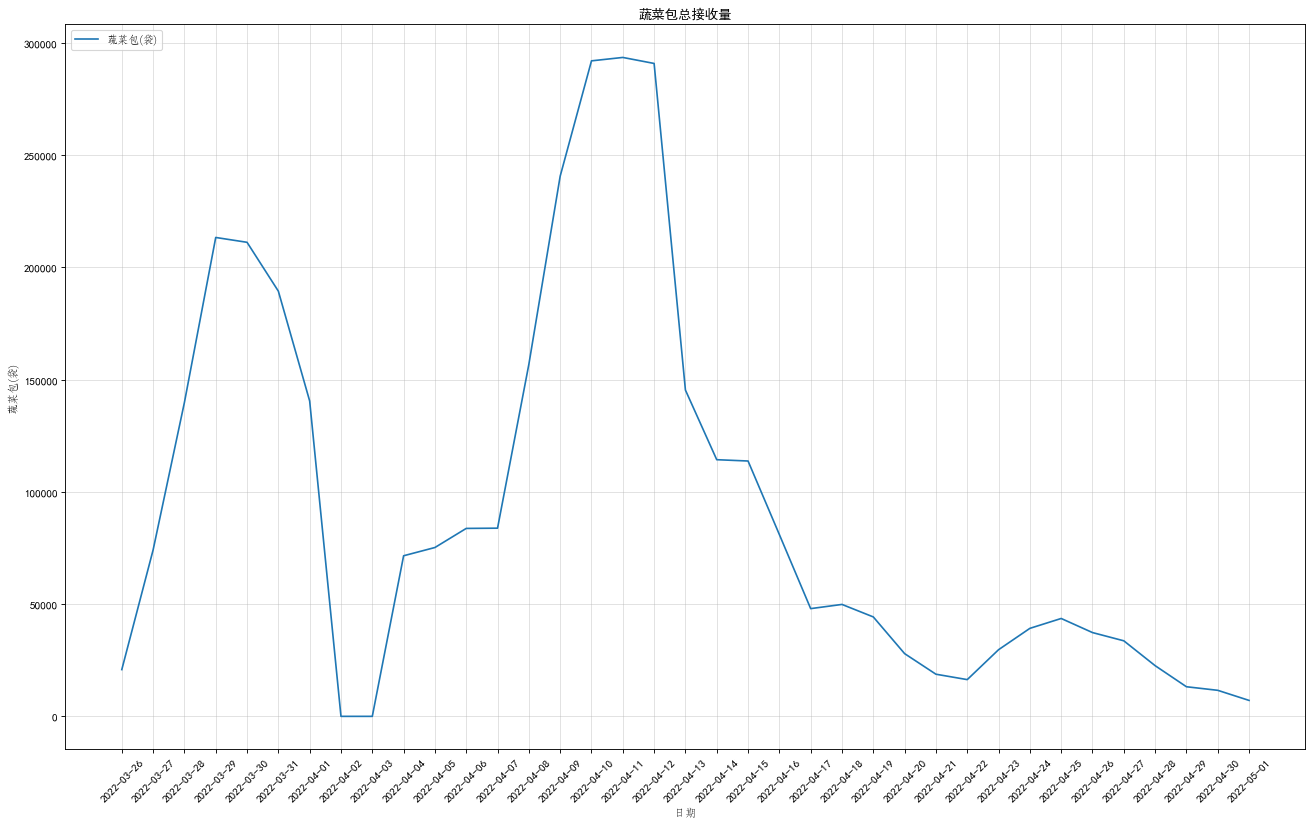

In [27]:
drawingSingBar(allVegatable_fillNan, "蔬菜包总接收量", 'date', 'hjjszcscb', 
                '日期', '蔬菜包(袋)', '蔬菜包(袋)', './pictures/蔬菜包总接收量.png', (20, 12))

发放的蔬菜包总袋数

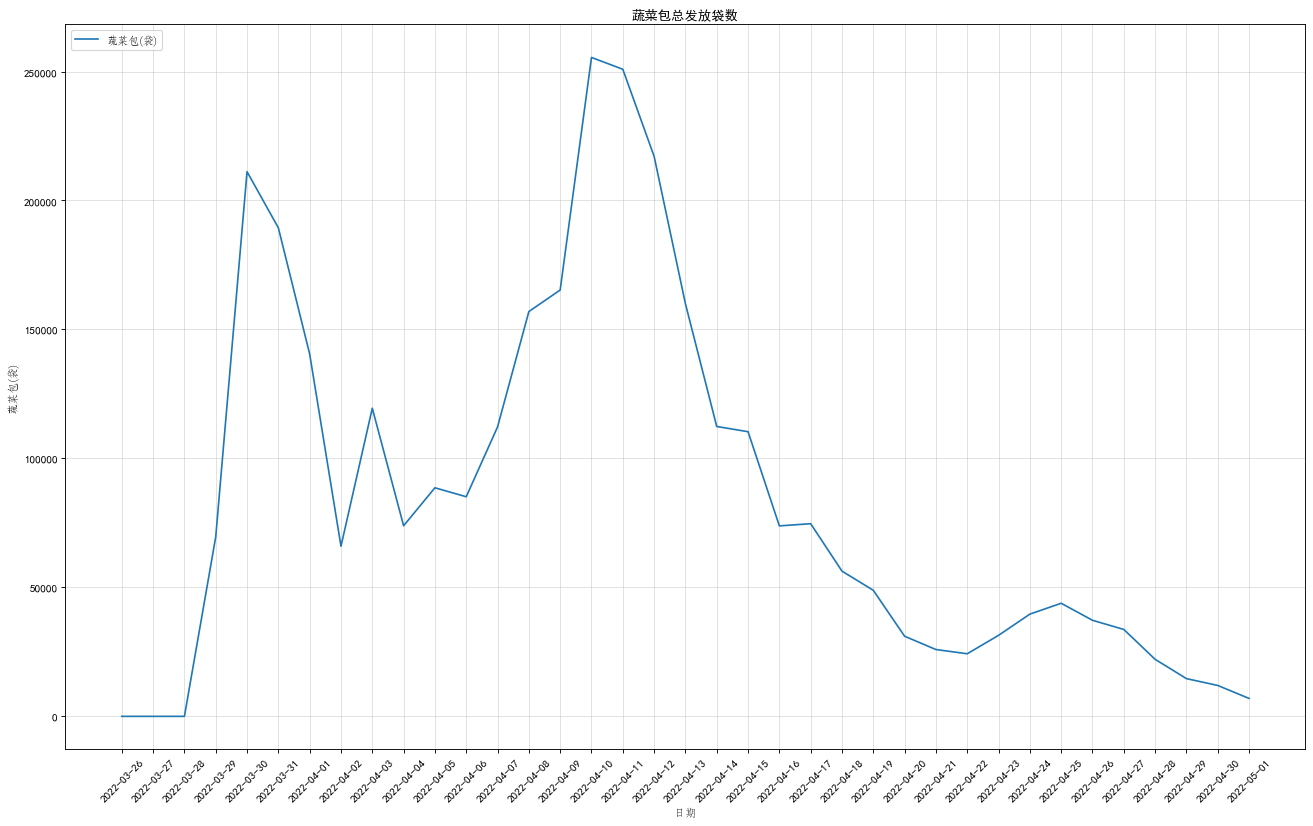

In [28]:
drawingSingBar(allVegatable_fillNan, "蔬菜包总发放袋数", 'date', 'hjffscb', 
                '日期', '蔬菜包(袋)', '蔬菜包(袋)', './pictures/蔬菜包总发放袋数.png', (20, 12))

读取疫情数据

In [29]:
nai = pd.read_csv('./data/input/1nai.csv', encoding='gb18030')
nalip = pd.read_csv('./data/input/1nalip.csv', encoding='gb18030')

In [30]:
def processTimeFormat(inputDateframe):
    
    if '日' not in inputDateframe['date']:
        inputDateframe['date'] = inputDateframe['date'] + '日'
    # print(inputDateframe['date'])
    inputDateframe['date'] = datetime.datetime.strptime("2022年" + inputDateframe['date'], "%Y年%m月%d日").strftime("%Y-%m-%d")
    return inputDateframe

In [31]:
# 全市总计新增无症状感染者
nai.rename(columns={'区域':'date', '全市总计':'all'}, inplace=True)
nai_all = nai[['date','all']].copy()
nai_all = nai_all.drop(81)
# print(nai_all)
nai_all = nai_all.apply(processTimeFormat, axis=1)
nai_all = nai_all.fillna(0)
nai_all

,date,all
0,2022-03-04,0.0
1,2022-03-05,0.0
2,2022-03-06,5.0
3,2022-03-07,6.0
4,2022-03-08,10.0
...,...,...
76,2022-05-19,0.0
77,2022-05-20,0.0
78,2022-05-21,0.0
79,2022-05-22,0.0


In [32]:
def processObjectToFloat(inputDataFrame):
    sum = 0
    if '+' in inputDataFrame['all']:
        strlist = inputDataFrame['all'].split('+')
        for x in strlist:
            sum += float(x)
        
        inputDataFrame['all'] = sum
    return inputDataFrame

In [33]:
# 新增本土感染者
nalip.rename(columns={'区域编号':'date', '全市总计':'all'}, inplace=True)
nalip_all = nalip[['date','all']].copy()
nalip_all = nalip_all.apply(processTimeFormat, axis=1)
nalip_all = nalip_all.fillna(0)
# nalip_all[['all']] = nalip_all[['all']].apply(pd.to_numeric)
nalip_all = nalip_all.apply(processObjectToFloat, axis=1)
nalip_all[['all']] = nalip_all[['all']].apply(pd.to_numeric)
print(nalip_all.dtypes)
print(nalip_all)

date     object
all     float64
dtype: object
          date   all
0   2022-03-04   5.0
1   2022-03-05   7.0
2   2022-03-06   7.0
3   2022-03-07  17.0
4   2022-03-08  12.0
..         ...   ...
76  2022-05-19   0.0
77  2022-05-20   0.0
78  2022-05-21   0.0
79  2022-05-22   0.0
80  2022-05-23   0.0

[81 rows x 2 columns]


In [34]:
nalip_all_number = nalip_all.copy()
nai_all_number = nai_all.copy()

将蔬菜输出和病毒数据的日期天数对齐。

In [35]:
allVegatableTemp = allVegatable_fillNan.copy()
addVegatableColumnNameList = VegatableColumnNameList
print(allVegatableTemp.shape)

(37, 18)


In [36]:
topAddRowNameList = createDateList("2022-03-04", "2022-03-25")
bottomAddRowNameList = createDateList("2022-05-02", "2022-05-23")

addVegatableColumnNameList.append('date')
print(len(addVegatableColumnNameList))

18


In [37]:
topAddDF = pd.DataFrame(index=topAddRowNameList, columns=addVegatableColumnNameList)
bottomAddDF = pd.DataFrame(index=bottomAddRowNameList, columns=addVegatableColumnNameList)
print(topAddDF.shape)
allVegatableTemp = pd.concat([topAddDF, allVegatableTemp])
allVegatableTemp = pd.concat([allVegatableTemp, bottomAddDF])
allVegatableTemp.describe()

print(allVegatableTemp.shape)

allVegatableTempjsdraw = allVegatableTemp[['date','hjjszcscb']].fillna(0).copy()
print(allVegatableTempjsdraw.shape)

allVegatableTempffdraw = allVegatableTemp[['date','hjffscb']].fillna(0).copy()
print(allVegatableTempffdraw.shape)

(22, 18)
(81, 18)
(81, 2)
(81, 2)


需要显示数据归一化处理

In [38]:
max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))

nai_all[['all']] = nai_all[['all']].apply(max_min_scaler)
print(nai_all)

nalip_all[['all']] = nalip_all[['all']].apply(max_min_scaler)
print(nalip_all)

allVegatableTempjsdraw[['hjjszcscb']] = allVegatableTempjsdraw[['hjjszcscb']].apply(max_min_scaler)
print(allVegatableTempjsdraw)

allVegatableTempffdraw[['hjjszcscb']] = allVegatableTempffdraw[['hjffscb']].apply(max_min_scaler)
print(allVegatableTempffdraw)


          date       all
0   2022-03-04  0.000000
1   2022-03-05  0.000000
2   2022-03-06  0.001613
3   2022-03-07  0.001935
4   2022-03-08  0.003226
..         ...       ...
76  2022-05-19  0.000000
77  2022-05-20  0.000000
78  2022-05-21  0.000000
79  2022-05-22  0.000000
80  2022-05-23  0.000000

[81 rows x 2 columns]
          date       all
0   2022-03-04  0.002527
1   2022-03-05  0.003537
2   2022-03-06  0.003537
3   2022-03-07  0.008590
4   2022-03-08  0.006064
..         ...       ...
76  2022-05-19  0.000000
77  2022-05-20  0.000000
78  2022-05-21  0.000000
79  2022-05-22  0.000000
80  2022-05-23  0.000000

[81 rows x 2 columns]
           date  hjjszcscb
2022-03-04    0        0.0
2022-03-05    0        0.0
2022-03-06    0        0.0
2022-03-07    0        0.0
2022-03-08    0        0.0
...         ...        ...
2022-05-19    0        0.0
2022-05-20    0        0.0
2022-05-21    0        0.0
2022-05-22    0        0.0
2022-05-23    0        0.0

[81 rows x 2 columns]
       

病毒数据和蔬菜包数据组合在一张图上。

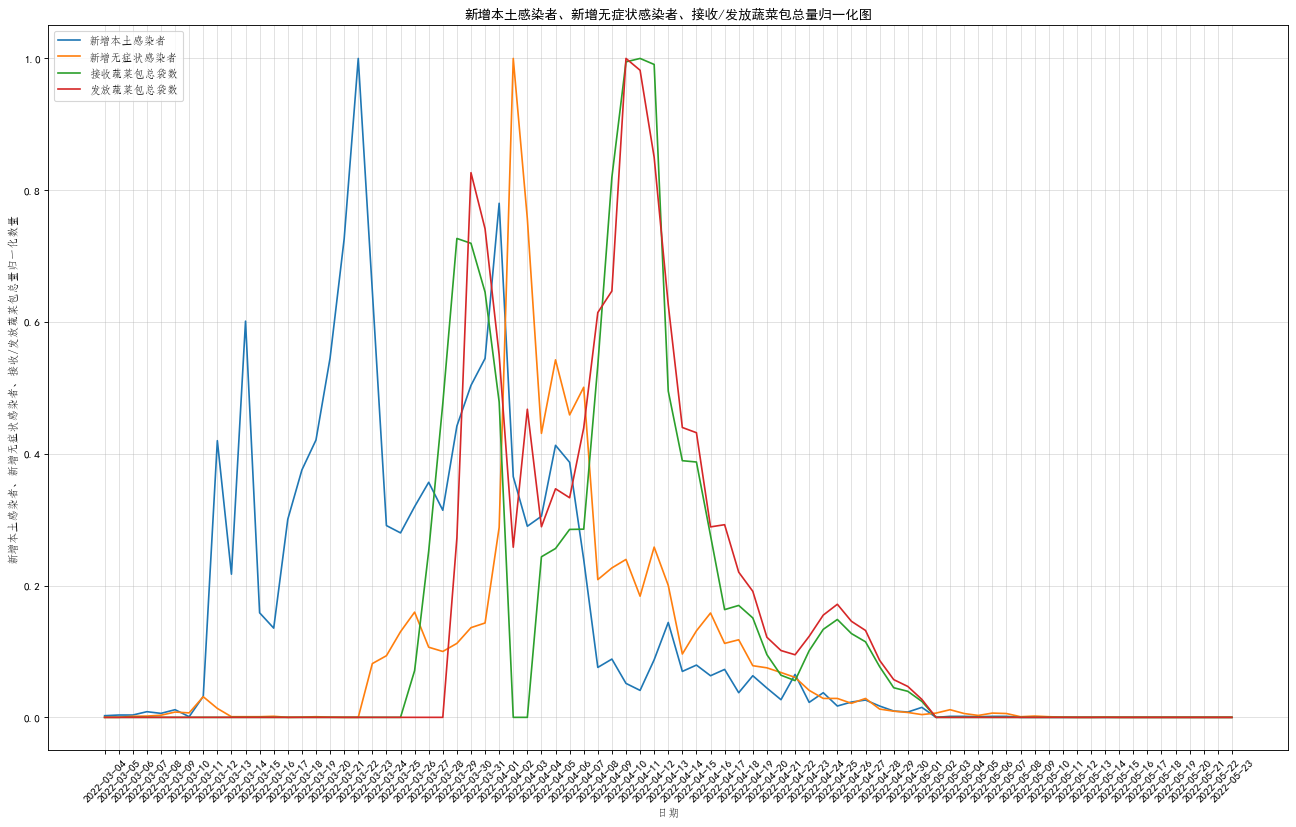

In [39]:

x = nalip_all['date']
y1 = nalip_all['all']
y2 = nai_all['all']
y3 = allVegatableTempjsdraw['hjjszcscb']
y4 = allVegatableTempffdraw['hjjszcscb']
fig = plt.figure(figsize=(20,12), dpi=80)
ax = fig.add_subplot(111)
ax.plot(x, y1, label='新增本土感染者')
ax.plot(x, y2, label='新增无症状感染者')
ax.plot(x, y3, label='接收蔬菜包总袋数')
ax.plot(x, y4, label='发放蔬菜包总袋数')
tick_spacing = 180
plt.xticks(rotation=45)
plt.xlabel('日期', fontproperties=myFont)
plt.ylabel('新增本土感染者、新增无症状感染者、接收/发放蔬菜包总量归一化数量', fontproperties=myFont)
plt.title('新增本土感染者、新增无症状感染者、接收/发放蔬菜包总量归一化图')
plt.grid(alpha=0.4)
plt.legend(prop=myFont, loc='upper left')
plt.savefig('./pictures/NaiNalipVegatableScaler.png')
plt.show()
plt.close()

将所有需要的数据做成一张表
SklcPD_FillNan

In [40]:
# 去掉不能归一化的date列。
SklcPD_FillNan = SklcPD_FillNan.drop('date', axis=1)

In [41]:

SklcPD_FillNan_Scale = SklcPD_FillNan.apply(max_min_scaler)
SklcPD_FillNan_Scale

,gtr,ggr,gike,gdo,gdp,gsd,grs,otr,ogr,oike,...,pdp,psd,prs,vtr,vgr,vike,vdo,vdp,vsd,vrs
2022-03-18,0.979965,1.0,1.000000,0.295720,0.210797,1.000000,1.0,0.968076,1.0,0.961538,...,0.298165,1.0,1.0,1.000000,0.000141,0.930986,0.484866,0.391061,1.0,1.0
2022-03-19,0.978147,1.0,0.992188,0.249027,0.120823,1.000000,1.0,1.000000,1.0,1.000000,...,0.424312,1.0,1.0,0.979495,0.000141,0.890141,0.471853,0.345531,1.0,1.0
2022-03-20,0.973568,1.0,0.992188,0.463035,0.187661,1.000000,1.0,0.984660,1.0,0.961538,...,0.339450,1.0,1.0,0.952635,0.000141,0.866197,0.423762,0.314525,1.0,1.0
2022-03-21,0.972042,1.0,0.992188,0.252918,0.177378,0.952381,1.0,0.984038,1.0,0.961538,...,0.272936,1.0,1.0,0.930571,0.000141,0.812676,0.436775,0.271788,1.0,1.0
2022-03-22,0.972269,1.0,0.992188,0.126459,0.177378,0.952381,1.0,0.983416,1.0,0.961538,...,0.272936,1.0,1.0,0.908807,0.000141,0.928169,0.408204,0.267039,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-19,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2022-05-20,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2022-05-21,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2022-05-22,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [42]:
topAddRowNameList = createDateList("2022-03-04", "2022-03-17")

topSklcPD = pd.DataFrame(index=topAddRowNameList, columns=sklcColoumnNameList)
# topSklcPD

In [43]:
allSklcTemp = pd.concat([topSklcPD, SklcPD_FillNan_Scale])

In [44]:
allSklcTemp = allSklcTemp.fillna(0)
allSklcTemp

,gtr,ggr,gike,gdo,gdp,gsd,grs,otr,ogr,oike,...,pdp,psd,prs,vtr,vgr,vike,vdo,vdp,vsd,vrs
2022-03-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-03-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-03-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-03-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
allVegatableTempffdraw = allVegatableTempffdraw.drop('date', axis=1)
allVegatableTempffdraw

,hjffscb,hjjszcscb
2022-03-04,0.0,0.0
2022-03-05,0.0,0.0
2022-03-06,0.0,0.0
2022-03-07,0.0,0.0
2022-03-08,0.0,0.0
...,...,...
2022-05-19,0.0,0.0
2022-05-20,0.0,0.0
2022-05-21,0.0,0.0
2022-05-22,0.0,0.0


In [46]:
nai_all.rename(columns={'all':'naiAll'}, inplace=True)
nai_all.set_index('date', inplace=True)
nai_all

,naiAll
date,
2022-03-04,0.000000
2022-03-05,0.000000
2022-03-06,0.001613
2022-03-07,0.001935
2022-03-08,0.003226
...,...
2022-05-19,0.000000
2022-05-20,0.000000
2022-05-21,0.000000


In [47]:
nalip_all.rename(columns={'all':'nalipAll'}, inplace=True)
nalip_all.set_index('date', inplace=True)
nalip_all

,nalipAll
date,
2022-03-04,0.002527
2022-03-05,0.003537
2022-03-06,0.003537
2022-03-07,0.008590
2022-03-08,0.006064
...,...
2022-05-19,0.000000
2022-05-20,0.000000
2022-05-21,0.000000


In [48]:
y_data_1 = nai_all.copy()
y_data_2 = nalip_all.copy()

In [49]:
# allSklcTemp   allVegatableTempffdraw  nai_all nalip_all   行是对齐的。合并到一起。

# x_data = pd.concat([allSklcTemp, allVegatableTempffdraw, nai_all[['naiAll']], nalip_all[['nalipAll']] ], axis=1)
x_data = pd.concat([allSklcTemp, allVegatableTempffdraw], axis=1)

x_data

,gtr,ggr,gike,gdo,gdp,gsd,grs,otr,ogr,oike,...,prs,vtr,vgr,vike,vdo,vdp,vsd,vrs,hjffscb,hjjszcscb
2022-03-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-03-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-03-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-03-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
x_data = x_data['2022-03-12':'2022-05-12']
x_data = x_data.drop('2022-03-31', axis=0)
x_data

,gtr,ggr,gike,gdo,gdp,gsd,grs,otr,ogr,oike,...,prs,vtr,vgr,vike,vdo,vdp,vsd,vrs,hjffscb,hjjszcscb
2022-03-12,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2022-03-13,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2022-03-14,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2022-03-15,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2022-03-16,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-08,0.539031,1.0,0.09375,1.000000,0.701799,0.523810,1.0,0.594320,1.0,0.057692,...,1.0,0.078482,0.0,0.121127,0.196040,0.122067,0.142857,1.0,0.0,0.0
2022-05-09,0.532959,1.0,0.09375,0.527237,0.704370,0.523810,1.0,0.579809,1.0,0.057692,...,1.0,0.073745,0.0,0.121127,0.124752,0.101676,0.142857,1.0,0.0,0.0
2022-05-10,0.535881,1.0,0.09375,0.319066,0.694087,0.523810,1.0,0.594113,1.0,0.057692,...,1.0,0.082439,0.0,0.121127,0.080905,0.119832,0.142857,1.0,0.0,0.0
2022-05-11,0.543415,1.0,0.09375,0.289883,0.982005,0.523810,1.0,0.596393,1.0,0.057692,...,1.0,0.072247,0.0,0.121127,0.109477,0.060615,0.142857,1.0,0.0,0.0


In [51]:
x_data.describe()

,gtr,ggr,gike,gdo,gdp,gsd,grs,otr,ogr,oike,...,prs,vtr,vgr,vike,vdo,vdp,vsd,vrs,hjffscb,hjjszcscb
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,...,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,0.547950,0.901639,0.191773,0.315494,0.360656,0.551913,0.901639,0.615308,0.901639,0.258531,...,0.901639,0.240371,0.032798,0.213828,0.291622,0.275817,0.309133,0.901639,48710.590164,0.190676
std,0.227586,0.300273,0.292480,0.196320,0.299324,0.228931,0.300273,0.242425,0.300273,0.299168,...,0.300273,0.261566,0.179554,0.269358,0.239266,0.239812,0.272530,0.300273,68388.033576,0.267703
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.544129,1.000000,0.093750,0.151751,0.082262,0.523810,1.000000,0.583541,1.000000,0.057692,...,1.000000,0.119552,0.000000,0.084507,0.137482,0.122067,0.142857,1.000000,0.000000,0.000000
50%,0.548967,1.000000,0.093750,0.319066,0.339332,0.571429,1.000000,0.614013,1.000000,0.057692,...,1.000000,0.162120,0.000000,0.109437,0.196040,0.199162,0.285714,1.000000,14629.000000,0.057265
75%,0.564099,1.000000,0.109375,0.437743,0.583548,0.571429,1.000000,0.732587,1.000000,0.342308,...,1.000000,0.225253,0.000000,0.201408,0.408204,0.328771,0.285714,1.000000,73895.000000,0.289260
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255462.000000,1.000000


In [52]:
# 无症状人数
y_data_1 = y_data_1['2022-03-12':'2022-05-12']
y_data_1 = y_data_1.drop('2022-03-31', axis=0)

In [53]:
# 本土感染人数
y_data_2 = y_data_2['2022-03-12':'2022-05-12']
y_data_2 = y_data_2.drop('2022-03-31', axis=0)

In [54]:
# 把感人人数相加之后综合成一列数据

# nalip_all_number
# nai_all_number

y_data = nai_all_number.set_index('date').add(nalip_all_number.set_index('date'), fill_value=0).reset_index()
y_data.set_index('date', inplace=True)
y_data = y_data['2022-03-12':'2022-05-12']
y_data = y_data.drop('2022-03-31', axis=0)
y_data[['all']] = y_data[['all']].apply(max_min_scaler)
y_data

,all
date,
2022-03-12,0.228355
2022-03-13,0.113262
2022-03-14,0.312059
2022-03-15,0.082919
2022-03-16,0.071410
...,...
2022-05-08,0.000785
2022-05-09,0.001569
2022-05-10,0.000785


In [55]:
x_data.to_csv('./data/output/x_data.csv')
y_data.to_csv('./data/output/y_data.csv')
y_data_1.to_csv('./data/output/y_data_1.csv')
y_data_2.to_csv('./data/output/y_data_2.csv')

## 4. 建模

划分数据集

In [56]:
from sklearn.model_selection import train_test_split

import xgboost as xgb
from xgboost import plot_importance

In [57]:
xs_train, xs_test, ys_train, ys_test = train_test_split(x_data, y_data, test_size=0.2, random_state=2020, shuffle=False)


In [58]:
xgbParams = {
    'booster':'gbtree',
    'objective':'reg:linear',
    'gamma':0.1,
    'max_depth':6,
    'lambda':2,
    'subsample':0.7,
    'colsample_bytree':0.7,
    'min_child_weight':3,
    'silent':1,
    'eta':0.1,
    'seed':1000,
    'nthread':4
}

dtrain = xgb.DMatrix(xs_train, ys_train)
plst = list(xgbParams.items())
# print(plst_dw)
num_rounds = 500
# , feature_names=list(x_feature_names)
model_xgb = xgb.train(plst, dtrain, num_rounds)
dtest = xgb.DMatrix(xs_test)
ans = model_xgb.predict(dtest)

DisplayCompletedInfo()

[13:17:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Completed at 2022-10-14 13:17:57.

-------------------------Completed-------------------------


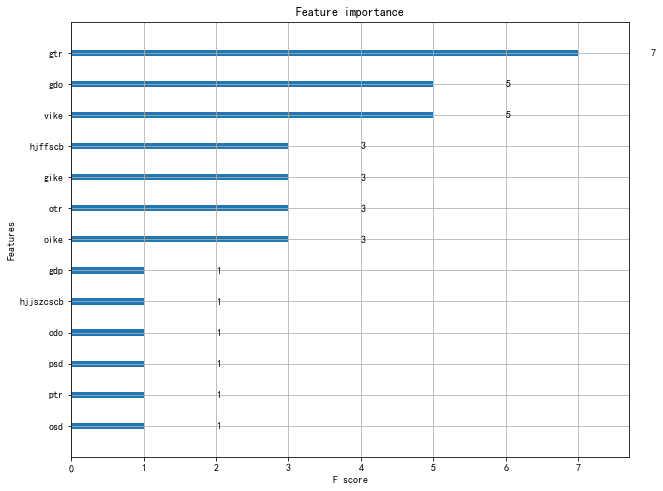

In [59]:
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(model_xgb, max_num_features=40, ax=ax)
# plt.figure(figsize=(96,72), dpi=100)
plt.savefig("./pictures/1xgboost_importance.png")
plt.show()

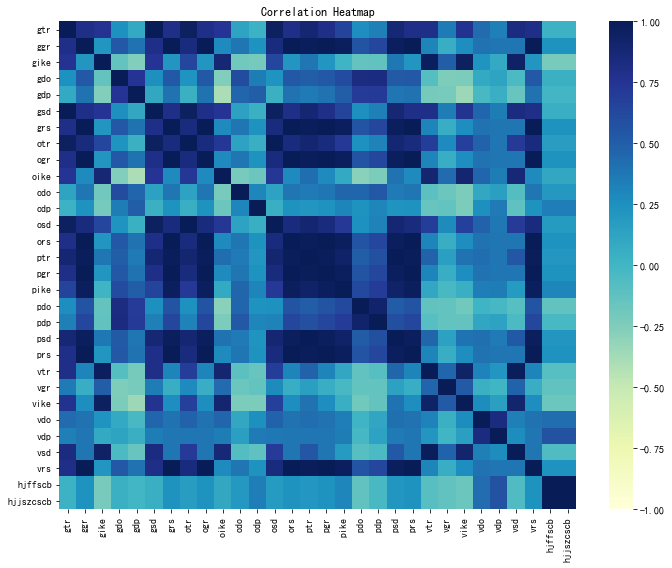

In [60]:
plt.figure(figsize=(10, 8))
fig = sns.heatmap(x_data.corr(), vmin=-1, vmax=1, cmap='YlGnBu') # annot=True, 
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig("./pictures/1correlation_heatmap.jpg")

第一问的另外一种思路：
当时好像说的是做类似股票买入卖出点的判断的。用LSTM或者encode decode模型。 

## 5. 第二问

1. 由于使用的是虚拟坐标系，所以不能使用互联网接口来显示坐标地址。
2. 不能使用POI数据了。
3. 地址中的长春新区(高新)、经开区、净月区、汽开区在标准地址中都不存在。

将地址信息读取进来。

In [61]:
pndpl = pd.read_csv('./data/input/2pndpl.csv', encoding='gb18030')
dmced = pd.read_csv('./data/input/3dmced.csv', encoding='gb18030')
tind = pd.read_csv('./data/input/3tind.csv', encoding='gb18030')
tird = pd.read_csv('./data/input/3tird.csv', encoding='gb18030')

In [62]:
pndpl

,区域名称,隔离人口数（万人）,生活物资投放点数量
0,朝阳区,57.8,94
1,南关区,48.9,261
2,宽城区,32.6,181
3,绿园区,38.5,470
4,二道区,42.6,9
5,长春新区(高新),36.8,215
6,经开区,20.3,37
7,净月区,22.8,279
8,汽开区,21.7,10


对大区进行编码：

|区域名称|编码|
|---|---|
|朝阳区|0|
|南关区|1|
|宽城区|2|
|绿园区|3|
|二道区|4|
|长春新区(高新)|5|
|经开区|6|
|净月区|7|
|汽开区|8|

In [63]:
locate = pndpl['区域名称'].tolist()
peoples = pndpl['隔离人口数（万人）'].tolist()
deliveryPoints = pndpl['生活物资投放点数量'].tolist()
list1 = [[locate[i], peoples[i]] for i in range(len(locate))]
map_1 = Map()
map_1.set_global_opts(
    title_opts=opts.TitleOpts(title="长春市隔离人口数"),
    visualmap_opts=opts.VisualMapOpts(max_=2500)  #最大数据范围
    )
map_1.add("长春市隔离人口数", list1, maptype="长春")
map_1.render('./data/output/peoplesMap.html')


list2 = [[locate[i], deliveryPoints[i]] for i in range(len(locate))]
map_2 = Map()
map_2.set_global_opts(
    title_opts=opts.TitleOpts(title="长春市生活物资投放点数量"),
    visualmap_opts=opts.VisualMapOpts(max_=2500)  #最大数据范围
    )
map_2.add("长春市隔离人口数", list2, maptype="长春")
map_2.render('./data/output/deliveryPointsMap.html')


'd:\\codeSpace\\HuaweiCupCompetition2022\\data\\output\\deliveryPointsMap.html'

In [64]:
dmced

,小区编号,小区栋数,小区户数（户）,小区人口数（人）,小区横坐标,小区纵坐标,街道编号,所属区域
0,1,11,1060,2417,57.90250,62.132333,C0035,宽城区
1,2,37,4171,9080,51.79225,61.606667,C0048,宽城区
2,3,3,480,1333,54.80225,54.881000,C0010,宽城区
3,4,19,1093,2658,54.21575,67.842333,C0053,宽城区
4,5,15,1330,3033,56.73050,61.479333,C0035,宽城区
...,...,...,...,...,...,...,...,...
1404,1405,5,231,908,25.50975,34.506333,I0032,汽开区
1405,1406,4,267,744,35.64725,40.527333,I0008,汽开区
1406,1407,2,185,727,26.07375,36.628333,I0008,汽开区
1407,1408,3,115,320,33.62550,36.866000,I0008,汽开区


In [65]:
tird

,路线编号,路线起点,路线终点,路线距离(m)
0,1,1,2,40.99
1,2,2,3,57.61
2,3,4,5,171.65
3,4,5,6,6.27
4,5,6,7,146.12
...,...,...,...,...
15320,15321,8410,9722,442.39
15321,15322,9932,9861,4.56
15322,15323,9861,9862,1236.28
15323,15324,9862,9865,15.34


In [66]:
tind

,节点编号,路口横坐标,路口纵坐标
0,1,87.952200,47.704267
1,2,87.925850,47.583900
2,3,87.888775,47.414733
3,4,50.265275,49.651667
4,5,49.761400,49.809700
...,...,...,...
9927,9928,46.524875,32.567500
9928,9929,68.326725,81.961800
9929,9930,68.264525,81.104300
9930,9931,68.535000,83.141900


具体思路：
1. 确立以虚拟坐标系为准的空间结构。
2. 使用“交通路口节点数据”中的数据建立节点。
3. 使用“交通路口路线数据”中的数据建边。
4. 使用“各区主要小区数据”中的数据设置为节点的特征。这里需要定义一个空间距离超参数。$\Delta l$。在节点特征中添加分类标签问题四种的分类标签。  也就是每个节点有个分类。
5. 由于使用的是虚拟坐标系，所以POI数据无法再使用了。节点的特征只有人数和交通特征。
6. 使用GNN对图结构进行分析。
7. 得出结论。

读取所有坐标信息，然后获得最大值和最小值，然后将他们按照超参数平均分块，然后按照分片建立节点。

In [67]:
coordinate1 = dmced[['小区横坐标', '小区纵坐标']].copy()
coordinate2 = tind[['路口横坐标', '路口纵坐标']].copy()

coordinate1.rename(columns={'小区横坐标':'h', '小区纵坐标':'z'}, inplace=True)
coordinate2.rename(columns={'路口横坐标':'h', '路口纵坐标':'z'}, inplace=True)

print(coordinate1.shape)
print(coordinate2.shape)

(1409, 2)
(9932, 2)


In [68]:
coordinate = pd.concat([coordinate1, coordinate2])
print(coordinate.shape)

cmax = coordinate.max()
cmin = coordinate.min()

print(cmax)
print(cmin)

(11341, 2)
h    98.922125
z    95.080700
dtype: float64
h    6.156000
z    0.062433
dtype: float64


虚拟坐标的范围是（0,0）-（100,100）。超参数按照1来进行分片，也就是$\Delta l = 1$。一共1万个节点。实际范围是（6.156000， 0.062433）-（98.922125， 95.080700）。

In [69]:
# 设置超参数

dl = 1
# 长春横坐标分片数量。
CCH = 100
# 长春纵坐标分片数量。
CCZ = 100

建立节点的特征，具体特征包含：

1. 具有的路口数量
2. 小区栋数
3. 小区户数（户）
4. 小区人口数（人）
5. 小区中包含的起点数量
6. 小区中包含的终点数量
7. 所属的区域
8. 作为标签的节点分类。一共分为3类：
   1. 网络上游是各项物资来源（每个区选一个地点，参赛队可自行根据坐标选择）。
   2. 中游是各项物资的集散地（**集散地数量自行选择，可以先按附件2设置，再调整优化**）。
   3. 网络下游是长春市所有小区。

**在建图的时候我们会做一个假设：“投放点的分布和人口数量正相关”**。然后将附件2里面的投放点按假设分配各各个小区。不然这个地方逻辑无法连上。

实际超参数只有一个：选址半径$\Delta l$。这个超参数确定了，就明确了“管辖范围小区个数及管辖范围内人口数”。因为“管辖范围小区个数及管辖范围内人口数”都是固定的。另外“选址位置及所属区域”也是确定的，原因是附件2中间并没有区分到小区，只区分到了大区。所以我们的超参数只有一个。

In [70]:
math.ceil(87.952200) * math.ceil(47.704267)

4224

In [71]:
def CalculateNodeByHZ(inputDataFrame):
    inputDataFrame['node'] = math.ceil(inputDataFrame['h']) * CCZ + math.ceil(inputDataFrame['z'])
    return inputDataFrame

In [72]:
tind_node = tind.copy()
tind_node['node'] = -1
tind_node.rename(columns={'节点编号':'nodeNumber', '路口横坐标':'h', '路口纵坐标':'z'}, inplace=True)
# print(tind_node)
# print(tind_node.columns)

tind_node = tind_node.apply(CalculateNodeByHZ, axis=1)
print(tind_node)

      nodeNumber          h          z    node
0            1.0  87.952200  47.704267  8848.0
1            2.0  87.925850  47.583900  8848.0
2            3.0  87.888775  47.414733  8848.0
3            4.0  50.265275  49.651667  5150.0
4            5.0  49.761400  49.809700  5050.0
...          ...        ...        ...     ...
9927      9928.0  46.524875  32.567500  4733.0
9928      9929.0  68.326725  81.961800  6982.0
9929      9930.0  68.264525  81.104300  6982.0
9930      9931.0  68.535000  83.141900  6984.0
9931      9932.0  64.885400  85.517133  6586.0

[9932 rows x 4 columns]


In [73]:
dmced.columns

Index(['小区编号', '小区栋数', '小区户数（户）', '小区人口数（人）', '小区横坐标', '小区纵坐标', '街道编号',
       '所属区域'],
      dtype='object')

对大区进行编码

|区域名称|编码|
|---|---|
|朝阳区|0|
|南关区|1|
|宽城区|2|
|绿园区|3|
|二道区|4|
|长春新区(高新)|5|
|经开区|6|
|净月区|7|
|汽开区|8|

In [74]:
def CalculateAreaCode(inputDataFrame):
    if '朝阳' in inputDataFrame['Area']:
        inputDataFrame['AreaCode'] = 0
    elif '南关' in inputDataFrame['Area']:
        inputDataFrame['AreaCode'] = 1
    elif '宽城' in inputDataFrame['Area']:
        inputDataFrame['AreaCode'] = 2
    elif '绿园' in inputDataFrame['Area']:
        inputDataFrame['AreaCode'] = 3
    elif '二道' in inputDataFrame['Area']:
        inputDataFrame['AreaCode'] = 4
    elif '长春新区' in inputDataFrame['Area']:
        inputDataFrame['AreaCode'] = 5
    elif '经开' in inputDataFrame['Area']:
        inputDataFrame['AreaCode'] = 6
    elif '净月' in inputDataFrame['Area']:
        inputDataFrame['AreaCode'] = 7
    elif '汽开' in inputDataFrame['Area']:
        inputDataFrame['AreaCode'] = 8
    else:
        inputDataFrame['AreaCode'] = -1
    
    return inputDataFrame

In [75]:
dmced_node = dmced.copy()
dmced_node['node'] = -1
dmced_node['AreaCode'] = -1
dmced_node.rename(columns={'小区编号':'Number', '小区栋数':'HouseCount', 
                           '小区户数（户）':'HomeCount', '小区人口数（人）':'Population', 
                           '小区横坐标':'h', '小区纵坐标':'z', '街道编号':'StreetNubmer', 
                           '所属区域':'Area'}, inplace=True)
# print(dmced_node)
# print(dmced_node.columns)

dmced_node = dmced_node.apply(CalculateNodeByHZ, axis=1)
dmced_node = dmced_node.apply(CalculateAreaCode, axis=1)

print(dmced_node)

      Number  HouseCount  HomeCount  Population         h          z  \
0          1          11       1060        2417  57.90250  62.132333   
1          2          37       4171        9080  51.79225  61.606667   
2          3           3        480        1333  54.80225  54.881000   
3          4          19       1093        2658  54.21575  67.842333   
4          5          15       1330        3033  56.73050  61.479333   
...      ...         ...        ...         ...       ...        ...   
1404    1405           5        231         908  25.50975  34.506333   
1405    1406           4        267         744  35.64725  40.527333   
1406    1407           2        185         727  26.07375  36.628333   
1407    1408           3        115         320  33.62550  36.866000   
1408    1409           1         48         134  45.32250  42.283000   

     StreetNubmer Area  node  AreaCode  
0           C0035  宽城区  5863         2  
1           C0048  宽城区  5262         2  
2           

将“街道编号”进行数值化

In [76]:
street = dmced_node[['StreetNubmer', 'node']].copy()
street1 = street.groupby('StreetNubmer').count()
street1.rename(columns={'node':'nodeCount'}, inplace=True)
# .rename(columns={'区域编号':'date', '全市总计':'all'}, inplace=True)
street1 = street1.reset_index()
street1 = street1.rename_axis('StreetID').reset_index()
street1

,StreetID,StreetNubmer,nodeCount
0,0,A0001,1
1,1,A0002,1
2,2,A0003,1
3,3,A0004,1
4,4,A0005,4
...,...,...,...
482,482,I0050,1
483,483,I0051,1
484,484,I0052,1
485,485,I0053,1


In [77]:
dmced_node.columns

Index(['Number', 'HouseCount', 'HomeCount', 'Population', 'h', 'z',
       'StreetNubmer', 'Area', 'node', 'AreaCode'],
      dtype='object')

In [78]:
street1.columns

Index(['StreetID', 'StreetNubmer', 'nodeCount'], dtype='object')

In [79]:
dmced_node = pd.merge(dmced_node, street1, on='StreetNubmer', how='left')

In [80]:
dmced_node.to_csv('./data/output/dmced_node.csv')

In [81]:
dmced_node = dmced_node.drop(labels=['h', 'z', 'Area', 'StreetNubmer'], axis=1)
dmced_node

,Number,HouseCount,HomeCount,Population,node,AreaCode,StreetID,nodeCount
0,1,11,1060,2417,5863,2,171,6
1,2,37,4171,9080,5262,2,184,2
2,3,3,480,1333,5555,2,146,2
3,4,19,1093,2658,5568,2,189,2
4,5,15,1330,3033,5762,2,171,6
...,...,...,...,...,...,...,...,...
1404,1405,5,231,908,2635,8,464,6
1405,1406,4,267,744,3641,8,440,3
1406,1407,2,185,727,2737,8,440,3
1407,1408,3,115,320,3437,8,440,3


将起点和终点对应为节点编号

In [82]:
tird.columns

Index(['路线编号', '路线起点', '路线终点', '路线距离(m)'], dtype='object')

pandas连接参考<https://www.cnblogs.com/ykit/p/12397924.html>

In [83]:
tird_node = tird.copy()
# tird_node['StartNode'] = -1
# tird_node['FinishNode'] = -1
tird_node.rename(columns={'路线编号':'Number', '路线起点':'Start', '路线终点':'Finish', 
                           '路线距离(m)':'Distance'}, inplace=True)
# allVegatableTempffdraw.drop('date', axis=1)
tind_node_temp = tind_node.copy()
tind_node_temp = tind_node_temp.drop('h', axis=1)
tind_node_temp = tind_node_temp.drop('z', axis=1)

tind_node_temp.rename(columns={'nodeNumber':'Start'}, inplace=True)

tird_node_s = pd.merge(tird_node, tind_node_temp, on='Start', how='left')

tird_node_s.rename(columns={'node':'StartNode'}, inplace=True)
tind_node_temp.rename(columns={'Start':'Finish'}, inplace=True)

tird_node_s_f = pd.merge(tird_node_s, tind_node_temp, on='Finish', how='left')
tird_node_s_f.rename(columns={'node':'FinishNode'}, inplace=True)
tird_node_s_f.to_csv('./data/output/tird_node_start_finish.csv')
tird_node_s_f

,Number,Start,Finish,Distance,StartNode,FinishNode
0,1,1,2,40.99,8848.0,8848.0
1,2,2,3,57.61,8848.0,8848.0
2,3,4,5,171.65,5150.0,5050.0
3,4,5,6,6.27,5050.0,5050.0
4,5,6,7,146.12,5050.0,5050.0
...,...,...,...,...,...,...
15320,15321,8410,9722,442.39,6884.0,6684.0
15321,15322,9932,9861,4.56,6586.0,6586.0
15322,15323,9861,9862,1236.28,6586.0,6889.0
15323,15324,9862,9865,15.34,6889.0,6889.0


生成特征表，特征包括：

1. 具有的路口数量
2. 小区栋数
3. 小区户数（户）
4. 小区人口数（人）
5. 所属的区域
6. 小区中包含的起点数量
7. 小区中包含的终点数量
8. 作为标签的节点分类。

生成空的特征数据集

In [84]:
nodeFeaturesIndexList = [i for i in range(CCH * CCZ)]
print(len(nodeFeaturesIndexList))
nodeFeaturesColumnList = ['intersectionCount', 'houseCount', 'homeCount', 
                          'population', 'area', 'startCount', 'finishCount', 'type']

10000


In [85]:
nodeFeatures = pd.DataFrame(index=nodeFeaturesIndexList)
nodeFeatures['node'] = nodeFeatures.index
nodeFeatures

,node
0,0
1,1
2,2
3,3
4,4
...,...
9995,9995
9996,9996
9997,9997
9998,9998


生成“具有的路口数量”特征

In [86]:
tind_f = tind_node.groupby('node').count()

tind_f.rename(columns={'nodeNumber':'intersectionCount'}, inplace=True)
tind_f = tind_f.drop(labels=['h', 'z'], axis=1)
tind_f = tind_f.rename_axis('node').reset_index()
tind_f

,node,intersectionCount
0,734.0,4
1,736.0,2
2,738.0,6
3,739.0,3
4,741.0,2
...,...,...
2941,9826.0,1
2942,9906.0,2
2943,9907.0,1
2944,9920.0,1


In [87]:
nodeFeatures = pd.merge(nodeFeatures, tind_f, on='node', how='left')

In [88]:
nodeFeatures.describe()

,node,intersectionCount
count,10000.00000,2946.000000
mean,4999.50000,3.371351
std,2886.89568,3.209480
min,0.00000,1.000000
25%,2499.75000,1.000000
50%,4999.50000,2.000000
75%,7499.25000,4.000000
max,9999.00000,28.000000


生成以下特征：

2. 小区栋数
3. 小区户数（户）
4. 小区人口数（人）
5. 所属的区域

In [89]:
dmced_node_1 = dmced_node[['HouseCount', 'HomeCount', 'Population', 'node']].copy()
dmced_node_2 = dmced_node[['node', 'AreaCode', 'StreetID', 'nodeCount']].copy()
print(dmced_node_1)
print(dmced_node_2)

      HouseCount  HomeCount  Population  node
0             11       1060        2417  5863
1             37       4171        9080  5262
2              3        480        1333  5555
3             19       1093        2658  5568
4             15       1330        3033  5762
...          ...        ...         ...   ...
1404           5        231         908  2635
1405           4        267         744  3641
1406           2        185         727  2737
1407           3        115         320  3437
1408           1         48         134  4643

[1409 rows x 4 columns]
      node  AreaCode  StreetID  nodeCount
0     5863         2       171          6
1     5262         2       184          2
2     5555         2       146          2
3     5568         2       189          2
4     5762         2       171          6
...    ...       ...       ...        ...
1404  2635         8       464          6
1405  3641         8       440          3
1406  2737         8       440          3
140

In [90]:
dmced_node_agg = dmced_node_1.groupby('node')
dmced_node_sum = dmced_node_agg.sum()
# dmced_node_sum
dmced_node_sum = dmced_node_sum.reset_index()
dmced_node_sum

,node,HouseCount,HomeCount,Population
0,1936,20,2231,4868
1,2128,13,1137,2620
2,2130,1,62,180
3,2136,15,677,1770
4,2137,20,2340,6118
...,...,...,...,...
990,9019,3,107,264
991,9020,11,306,774
992,9120,11,364,980
993,9221,5,169,551


In [91]:
nodeFeatures = pd.merge(nodeFeatures, dmced_node_sum, on='node', how='left')

In [92]:
nodeFeatures.describe()

,node,intersectionCount,HouseCount,HomeCount,Population
count,10000.00000,2946.000000,995.000000,995.000000,995.000000
mean,4999.50000,3.371351,17.287437,1246.684422,3035.000000
std,2886.89568,3.209480,18.249109,1101.263929,2692.390155
min,0.00000,1.000000,1.000000,28.000000,82.000000
25%,2499.75000,1.000000,7.000000,491.000000,1181.000000
50%,4999.50000,2.000000,12.000000,926.000000,2260.000000
75%,7499.25000,4.000000,22.000000,1652.500000,3859.500000
max,9999.00000,28.000000,251.000000,13305.000000,29666.000000


In [93]:
dmced_node_2.drop_duplicates(subset=['node'], inplace=True)
dmced_node_2

,node,AreaCode,StreetID,nodeCount
0,5863,2,171,6
1,5262,2,184,2
2,5555,2,146,2
3,5568,2,189,2
4,5762,2,171,6
...,...,...,...,...
1397,3239,8,464,6
1404,2635,8,464,6
1406,2737,8,440,3
1407,3437,8,440,3


In [94]:
nodeFeatures = pd.merge(nodeFeatures, dmced_node_2, on='node', how='left')

In [95]:
nodeFeatures.describe()

,node,intersectionCount,HouseCount,HomeCount,Population,AreaCode,StreetID,nodeCount
count,10000.00000,2946.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000
mean,4999.50000,3.371351,17.287437,1246.684422,3035.000000,3.764824,246.957789,4.398995
std,2886.89568,3.209480,18.249109,1101.263929,2692.390155,2.642892,136.392868,2.745510
min,0.00000,1.000000,1.000000,28.000000,82.000000,0.000000,0.000000,1.000000
25%,2499.75000,1.000000,7.000000,491.000000,1181.000000,1.000000,133.000000,2.000000
50%,4999.50000,2.000000,12.000000,926.000000,2260.000000,3.000000,249.000000,4.000000
75%,7499.25000,4.000000,22.000000,1652.500000,3859.500000,6.000000,361.500000,6.000000
max,9999.00000,28.000000,251.000000,13305.000000,29666.000000,8.000000,485.000000,10.000000


生成以下特征：

6. 小区中包含的起点数量
7. 小区中包含的终点数量
8. 作为标签的节点分类。

In [96]:
tird_node_features = tird_node_s_f[['Number', 'StartNode', 'FinishNode']]
tird_node_StartNode = tird_node_features.groupby('StartNode').count()
tird_node_StartNode = tird_node_StartNode.rename_axis('node').reset_index()
tird_node_StartNode = tird_node_StartNode.drop('FinishNode', axis=1)
tird_node_StartNode.rename(columns={'Number':'StartCount'}, inplace=True)
print(tird_node_StartNode)

tird_node_FinishNode = tird_node_features.groupby('FinishNode').count()
tird_node_FinishNode = tird_node_FinishNode.rename_axis('node').reset_index()
tird_node_FinishNode = tird_node_FinishNode.drop('StartNode', axis=1)
tird_node_FinishNode.rename(columns={'Number':'FinishNode'}, inplace=True)
print(tird_node_FinishNode)

        node  StartCount
0      734.0           5
1      736.0           3
2      738.0           7
3      739.0           5
4      741.0           3
...      ...         ...
2909  9822.0           2
2910  9826.0           1
2911  9906.0           2
2912  9907.0           1
2913  9920.0           1

[2914 rows x 2 columns]
        node  FinishNode
0      734.0           7
1      736.0           4
2      738.0           7
3      739.0           4
4      741.0           3
...      ...         ...
2918  9826.0           1
2919  9906.0           2
2920  9907.0           1
2921  9920.0           1
2922  9921.0           2

[2923 rows x 2 columns]


In [97]:
nodeFeatures = pd.merge(nodeFeatures, tird_node_StartNode, on='node', how='left')

In [98]:
nodeFeatures = pd.merge(nodeFeatures, tird_node_FinishNode, on='node', how='left')

In [99]:
nodeFeatures.describe()

,node,intersectionCount,HouseCount,HomeCount,Population,AreaCode,StreetID,nodeCount,StartCount,FinishNode
count,10000.00000,2946.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,2914.000000,2923.000000
mean,4999.50000,3.371351,17.287437,1246.684422,3035.000000,3.764824,246.957789,4.398995,5.259094,5.242901
std,2886.89568,3.209480,18.249109,1101.263929,2692.390155,2.642892,136.392868,2.745510,5.175379,5.188294
min,0.00000,1.000000,1.000000,28.000000,82.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,2499.75000,1.000000,7.000000,491.000000,1181.000000,1.000000,133.000000,2.000000,2.000000,2.000000
50%,4999.50000,2.000000,12.000000,926.000000,2260.000000,3.000000,249.000000,4.000000,4.000000,4.000000
75%,7499.25000,4.000000,22.000000,1652.500000,3859.500000,6.000000,361.500000,6.000000,7.000000,7.000000
max,9999.00000,28.000000,251.000000,13305.000000,29666.000000,8.000000,485.000000,10.000000,51.000000,53.000000


In [100]:
nodeFeatures = nodeFeatures.drop('nodeCount', axis=1)

完成节点特征组装

保留一份包含NaN的数据。

In [101]:
nodeFeatures.to_csv('./data/output/nodeFeatures_containNan.csv')

将NaN的值都赋值为0。

In [102]:
nodeFeatures = nodeFeatures.fillna(0)

In [103]:
nodeFeatures.describe()

,node,intersectionCount,HouseCount,HomeCount,Population,AreaCode,StreetID,StartCount,FinishNode
count,10000.00000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,0.993200,1.72010,124.045100,301.982500,0.374600,24.572300,1.532500,1.532500
std,2886.89568,2.322949,7.73864,509.739586,1243.392599,1.401596,85.524231,3.676234,3.681453
min,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2499.75000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4999.50000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7499.25000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,9999.00000,28.000000,251.00000,13305.000000,29666.000000,8.000000,485.000000,51.000000,53.000000


将所有特征归一化。

In [104]:
nodeFeatures[['intersectionCount', 'HouseCount', 'HomeCount', 'Population',
       'AreaCode', 'StreetID', 'StartCount', 'FinishNode']] \
        = nodeFeatures[['intersectionCount', 'HouseCount', 'HomeCount', 'Population',
       'AreaCode', 'StreetID', 'StartCount', 'FinishNode']].apply(max_min_scaler)


In [105]:
nodeFeatures_DF = nodeFeatures.copy()

In [106]:
nodeFeatures.describe()

,node,intersectionCount,HouseCount,HomeCount,Population,AreaCode,StreetID,StartCount,FinishNode
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,0.035471,0.006853,0.009323,0.010179,0.046825,0.050665,0.030049,0.028915
std,2886.89568,0.082962,0.030831,0.038312,0.041913,0.175199,0.176339,0.072083,0.069461
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2499.75000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4999.50000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7499.25000,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,0.019608,0.018868
max,9999.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


赋值给tf.Variable()

In [107]:
nodeFeatures = tf.Variable(nodeFeatures)

### 生成节点之间的连接关系

也就是生成边。包括边的特征，也就是节点之间的距离。


In [108]:
tird_node_s_f

,Number,Start,Finish,Distance,StartNode,FinishNode
0,1,1,2,40.99,8848.0,8848.0
1,2,2,3,57.61,8848.0,8848.0
2,3,4,5,171.65,5150.0,5050.0
3,4,5,6,6.27,5050.0,5050.0
4,5,6,7,146.12,5050.0,5050.0
...,...,...,...,...,...,...
15320,15321,8410,9722,442.39,6884.0,6684.0
15321,15322,9932,9861,4.56,6586.0,6586.0
15322,15323,9861,9862,1236.28,6586.0,6889.0
15323,15324,9862,9865,15.34,6889.0,6889.0


将StartNode和FinishNode不相同的数据选择出来。

In [109]:
edges = tird_node_s_f.loc[tird_node_s_f['StartNode']!=tird_node_s_f['FinishNode']].copy()
edges

,Number,Start,Finish,Distance,StartNode,FinishNode
2,3,4,5,171.65,5150.0,5050.0
5,6,7,8,69.62,5050.0,5051.0
6,7,9,10,72.61,8044.0,8043.0
7,8,10,11,283.49,8043.0,8143.0
9,10,12,13,95.80,8143.0,8144.0
...,...,...,...,...,...,...
15316,15317,5247,9930,377.49,7082.0,6982.0
15317,15318,5245,9931,291.66,7084.0,6984.0
15318,15319,9931,9869,396.06,6984.0,6884.0
15320,15321,8410,9722,442.39,6884.0,6684.0


In [110]:
edges.columns

Index(['Number', 'Start', 'Finish', 'Distance', 'StartNode', 'FinishNode'], dtype='object')

In [111]:
def ComposeEdgeInfo(inputDataFrame):
    """_summary_
    让编号小的Node防前面，然后组成一个字符串。
    Args:
        inputDataFrame (_type_): _description_

    Returns:
        _type_: _description_
    """
    tmpS = int(inputDataFrame['StartNode'])
    tmpF = int(inputDataFrame['FinishNode'])
    # print(str(tmpS), str(tmpF))
    forwardString = str(tmpS)
    backwardString = str(tmpF)
    if inputDataFrame['StartNode'] > inputDataFrame['FinishNode']:
        forwardString = str(tmpF)
        backwardString = str(tmpS)
    # print(forwardString, backwardString)
    inputDataFrame['EdgeInfo'] = int(forwardString + backwardString)
    return inputDataFrame

In [112]:
# 设置边的信息，用于边的去重。将起点和终点先比较一个大小，然后组合成一个字符串作为边的标识符，
# 然后对标识符去重。从而达到对边去重的目的。
edges['EdgeInfo'] = 0
edges['StartNode'] = edges['StartNode'].astype('int')
edges['FinishNode'] = edges['FinishNode'].astype('int')
edges = edges.apply(ComposeEdgeInfo, axis=1)
edges.drop_duplicates(subset=['EdgeInfo'], inplace=True)
edges

,Number,Start,Finish,Distance,StartNode,FinishNode,EdgeInfo
2,3.0,4.0,5.0,171.65,5150.0,5050.0,50505150.0
5,6.0,7.0,8.0,69.62,5050.0,5051.0,50505051.0
6,7.0,9.0,10.0,72.61,8044.0,8043.0,80438044.0
7,8.0,10.0,11.0,283.49,8043.0,8143.0,80438143.0
9,10.0,12.0,13.0,95.80,8143.0,8144.0,81438144.0
...,...,...,...,...,...,...,...
15314,15315.0,9931.0,8574.0,655.83,6984.0,6986.0,69846986.0
15317,15318.0,5245.0,9931.0,291.66,7084.0,6984.0,69847084.0
15318,15319.0,9931.0,9869.0,396.06,6984.0,6884.0,68846984.0
15320,15321.0,8410.0,9722.0,442.39,6884.0,6684.0,66846884.0


In [113]:
edges = edges.sort_values(by='EdgeInfo')
edges['StartNode'] = edges['StartNode'].astype('int')
edges['FinishNode'] = edges['FinishNode'].astype('int')
edges['EdgeInfo'] = edges['EdgeInfo'].astype('int')
edges

,Number,Start,Finish,Distance,StartNode,FinishNode,EdgeInfo
10558,10559.0,8014.0,8015.0,498.27,734,736,734736
10529,10530.0,7993.0,7994.0,18.74,834,734,734834
10997,10998.0,8199.0,8014.0,511.60,935,734,734935
10559,10560.0,8015.0,8016.0,630.96,736,738,736738
12282,12283.0,8199.0,8015.0,761.12,935,736,736935
...,...,...,...,...,...,...,...
11984,11985.0,8604.0,8605.0,1003.38,9826,9527,95279826
11983,11984.0,8602.0,8604.0,1449.47,9822,9826,98229826
11981,11982.0,8602.0,8603.0,739.98,9822,9921,98229921
9379,9380.0,7353.0,6399.0,315.58,9906,9907,99069907


In [114]:
edges.to_csv("./data/output/edge_features.csv")

In [115]:
# type(edges['StartNode'].tolist())

In [116]:
u = tf.constant(edges['StartNode'].tolist())
v = tf.constant(edges['FinishNode'].tolist())

# u = edges['StartNode'].tolist()
# v = edges['FinishNode'].tolist()

print(len(u))

5433


将距离作为边的权重

In [117]:
edges_DF = edges.copy()

edgeFeature = tf.Variable(edges['Distance'].tolist())
edgeFeature

<tf.Variable 'Variable:0' shape=(5433,) dtype=float32, numpy=array([498.27,  18.74, 511.6 , ..., 739.98, 315.58, 408.18], dtype=float32)>

## 组装图结构

由于是无向图所以在DGL中边的数量乘以了2。去重之后的边数量为5433。

In [118]:
G = dgl.graph((u,v), num_nodes=CCH * CCZ)

部分图结构的可视化。

In [119]:
u = edges['StartNode'].tolist()
v = edges['FinishNode'].tolist()

up = u[0:50]
vp = v[0:50]

In [120]:
tmpList = up + vp
# print(tmpList)
print(up)
tmpList1 = list(set(tmpList))

# print(len(tmpList))
# print(max(tmpList))
# print(min(tmpList))

# tmpList2 = [x - min(tmpList) for x in tmpList]
# print(tmpList2)
# print(len(tmpList2))
# print(max(tmpList2))
# print(min(tmpList2))

tmpList2 = [x for x in range(len(tmpList1))]
# print(tmpList3)
u_new = []
for ue in up:
    ui=tmpList1.index(ue)
    u_new.append(ui)
print(u_new)
print(len(u_new))

v_new = []
for ve in vp:
    vi=tmpList1.index(ve)
    v_new.append(vi)
print(v_new)

[734, 834, 935, 736, 935, 739, 741, 838, 739, 739, 742, 843, 742, 742, 931, 837, 934, 839, 838, 838, 838, 942, 838, 840, 840, 844, 845, 845, 939, 941, 942, 942, 1034, 1040, 1128, 934, 935, 939, 939, 1040, 942, 1148, 943, 944, 1131, 1134, 1034, 1240, 1041, 1042]
[26, 16, 8, 27, 8, 29, 30, 18, 29, 29, 31, 21, 31, 31, 6, 17, 7, 19, 18, 18, 18, 13, 18, 20, 20, 22, 23, 23, 10, 12, 13, 13, 0, 1, 32, 7, 8, 10, 10, 1, 13, 35, 14, 15, 33, 34, 0, 25, 2, 3]
50
[27, 26, 26, 28, 27, 28, 29, 29, 19, 20, 30, 31, 22, 13, 16, 18, 17, 18, 9, 10, 11, 18, 14, 19, 12, 21, 22, 15, 9, 11, 12, 14, 16, 20, 6, 4, 0, 1, 2, 11, 3, 13, 35, 5, 0, 0, 24, 1, 3, 5]


In [121]:
GPartDisplay = dgl.graph((u_new,v_new), num_nodes=len(tmpList))

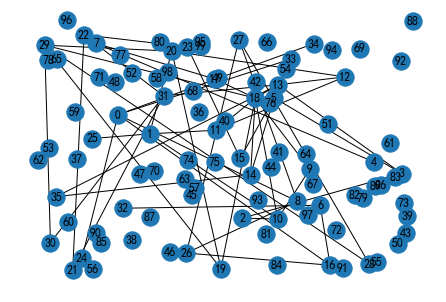

In [122]:
nx_G = GPartDisplay.to_networkx().to_undirected()
pos = nx.random_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True)
plt.savefig('./pictures/partofGraphStructure1.png')
plt.show()

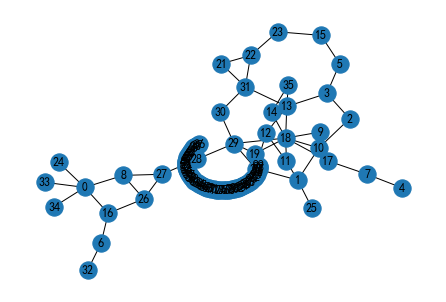

In [123]:
nx_G = GPartDisplay.to_networkx().to_undirected()
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True)
plt.savefig('./pictures/partofGraphStructure2.png')
plt.show()

完整的图太大了就不要画出来了。

In [124]:
# nx.draw(BG.to_networkx(), with_labels=True)

# nx_G = BG.to_networkx().to_undirected()
# pos = nx.kamada_kawai_layout(nx_G)
# nx.draw(nx_G, pos, with_labels=True)
# plt.show()

需要对图中的节点和边的属性进行赋值了。

In [125]:
# nodeFeaturesDF = pd.DataFrame(nodeFeatures)
# edgeFeatureDF = pd.DataFrame(edgeFeature)

In [126]:
G.ndata['NodeFeature'] = nodeFeatures
G.edata['EdgeFeature'] = edgeFeature

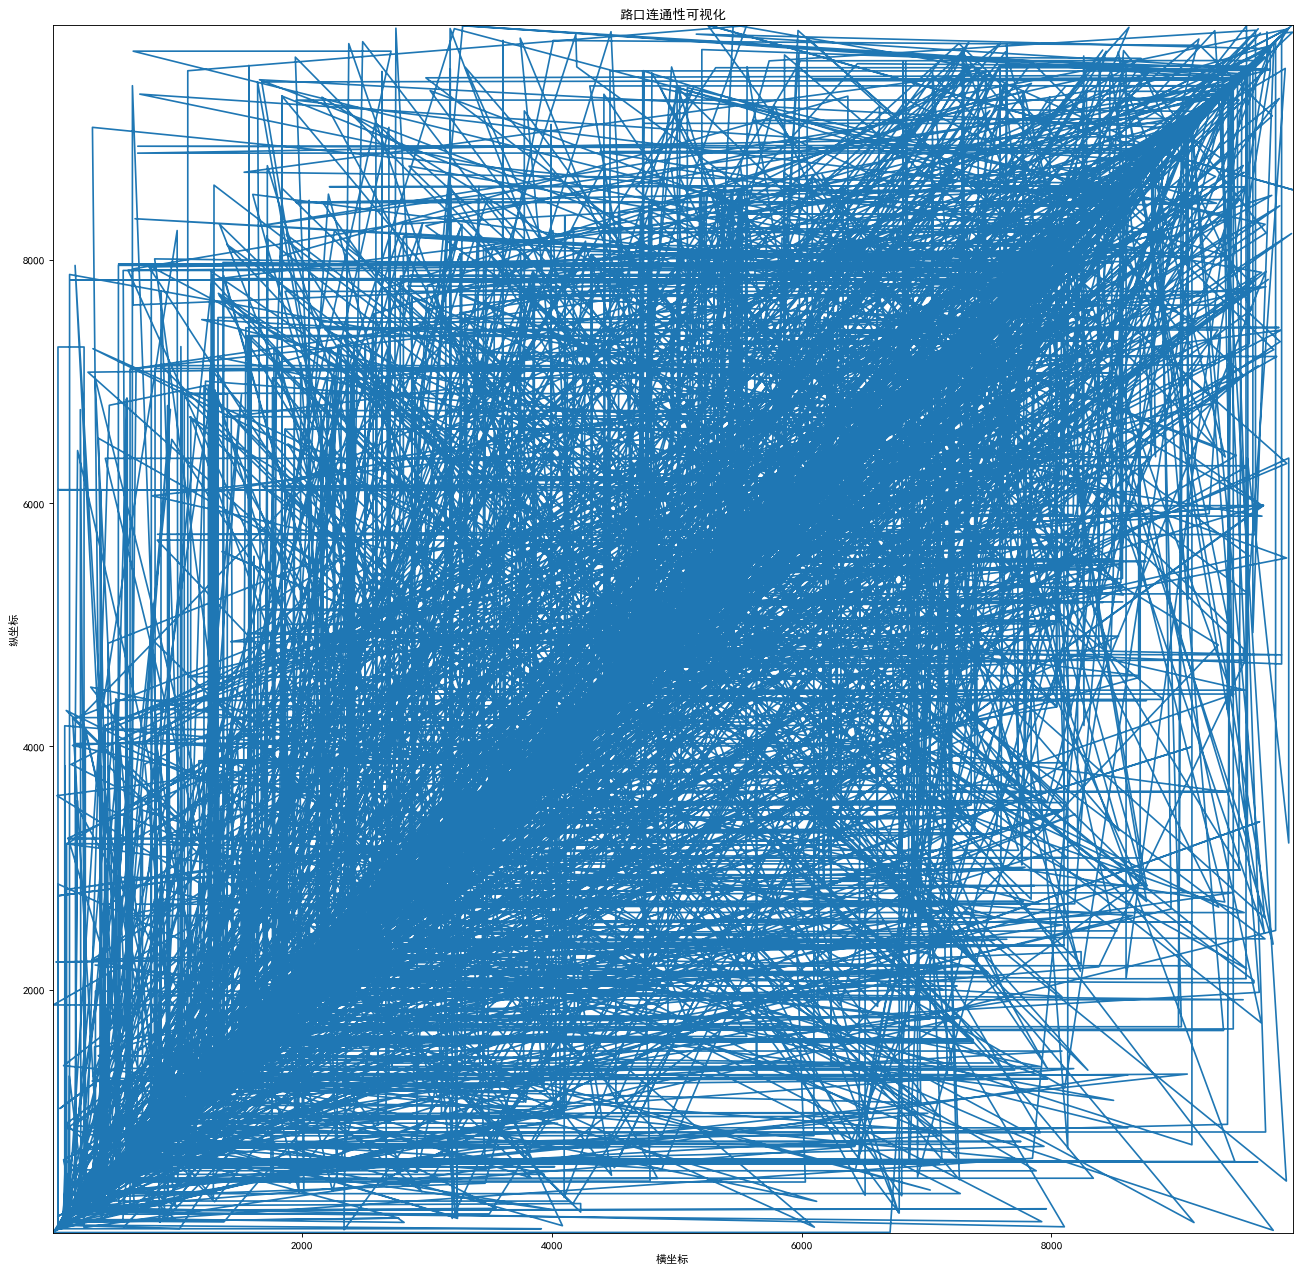

In [127]:
# 路口连通性可视化。

# aviator pilot copilot
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

u = edges['Start'].tolist()
v = edges['Finish'].tolist()
fig = plt.figure(figsize=(20,20), dpi=80)
plt.ylim((min(u),max(u)))
plt.xlim((min(v),max(v)))
 
plt.title("路口连通性可视化")
plt.xlabel("横坐标")#定义x坐标轴名称
plt.ylabel("纵坐标")#定义y坐标轴名称

plt.plot(u, v)#绘图
plt.savefig("./pictures/路口连通性_去重图.png")
plt.show()

In [128]:
# print(BG)
print(G)

Graph(num_nodes=10000, num_edges=5433,
      ndata_schemes={'NodeFeature': Scheme(shape=(9,), dtype=tf.float64)}
      edata_schemes={'EdgeFeature': Scheme(shape=(), dtype=tf.float32)})


由于数据中并没有提供虚拟坐标中分块的分类标签信息，所以直接使用聚类算法对节点数据进行分类。共分为3类，第一类是接收物资的点，第二类是分发点，第三类是物资存储点。

In [129]:
# index_list = [i for i in range(10000)]

# def CalculateNodeByHZ(inputDataFrame):
#     inputDataFrame['node'] = math.ceil(inputDataFrame['h']) * CCZ + math.ceil(inputDataFrame['z'])
#     return inputDataFrame

def CalculateXYByHZ(inputDataFrame):
    inputDataFrame['X'] = math.ceil(inputDataFrame['h']) 
    inputDataFrame['Y'] = math.ceil(inputDataFrame['z'])
    return inputDataFrame

def CalculateXYByNodeNumber(inputDataFrame):
    inputDataFrame['X'] = math.floor(inputDataFrame['node']/CCZ)
    inputDataFrame['Y'] = inputDataFrame['node']%CCZ
    return inputDataFrame

In [130]:
nodeFeatures_DF_XY = nodeFeatures_DF.apply(CalculateXYByNodeNumber, axis=1).copy()
nodeFeatures_DF = nodeFeatures_DF.drop('node', axis=1)

In [131]:
nodeFeatures_DF

,intersectionCount,HouseCount,HomeCount,Population,AreaCode,StreetID,StartCount,FinishNode
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [132]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(nodeFeatures_DF)

In [133]:
labelList = kmeans.labels_.tolist()
# print(labelList)
labelSet = set(kmeans.labels_)
print(labelSet)
labelDict = {}

for item in labelSet:
    labelDict.update({item:labelList.count(item)})

print(labelDict)

{0, 1, 2}
{0: 8624, 1: 766, 2: 610}


将生成的聚类标签放到数据集上。

In [134]:
nodeFeatures_DF['category'] = labelList

In [135]:
nodeFeatures_DF.describe()

,intersectionCount,HouseCount,HomeCount,Population,AreaCode,StreetID,StartCount,FinishNode,category
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,0.035471,0.006853,0.009323,0.010179,0.046825,0.050665,0.030049,0.028915,0.19860
std,0.082962,0.030831,0.038312,0.041913,0.175199,0.176339,0.072083,0.069461,0.53027
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,0.019608,0.018868,0.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.00000


节点类别的可视化。

In [144]:
nodeFeatures_DF_XY['category'] = labelList


,node,intersectionCount,HouseCount,HomeCount,Population,AreaCode,StreetID,StartCount,FinishNode,X,Y,category
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0
3,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.0,95.0,0
9996,9996.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.0,96.0,0
9997,9997.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.0,97.0,0
9998,9998.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.0,98.0,0


In [ ]:
nodeFeatures_DF_XY['color'] = ""

In [154]:
def CalculateColorByCategory(inputDataFrame):
    if inputDataFrame['category'] == 0 :
        inputDataFrame['color'] = 'gray'
    elif inputDataFrame['category'] == 1 :
        inputDataFrame['color'] = 'yellow'
    elif inputDataFrame['category'] == 2 :
        inputDataFrame['color'] = 'red'
    return inputDataFrame

nodeFeatures_DF_XY = nodeFeatures_DF_XY.apply(CalculateColorByCategory, axis=1)
nodeFeatures_DF_XY

,node,intersectionCount,HouseCount,HomeCount,Population,AreaCode,StreetID,StartCount,FinishNode,X,Y,category,color
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,gray
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,gray
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,gray
3,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0,gray
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0,gray
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.0,95.0,0,gray
9996,9996.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.0,96.0,0,gray
9997,9997.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.0,97.0,0,gray
9998,9998.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.0,98.0,0,gray


In [ ]:
import matplotlib


matplotlib.cm.get_cmp


# colormap.p

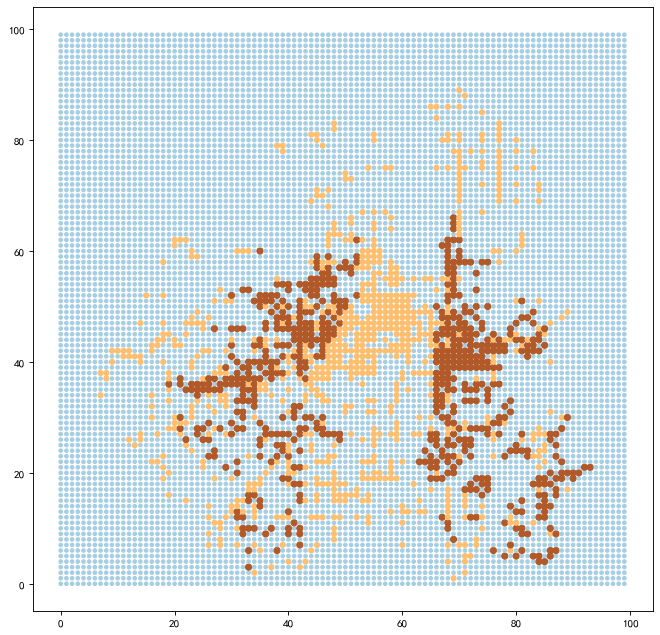

In [165]:
# 因为标签中有值等于0，在计算画图中的点的大小时会导致大小为0，所以将所有的标签值加1之后在计算大小。
labelList_s = [i+1 for i in labelList]
# print(labelList_s)
# 10*np.array(label), np.array(label)
fig = plt.figure(figsize=(10,10), dpi=80)
# plt.scatter(nodeFeatures_DF_XY['X'], nodeFeatures_DF_XY['Y'], 
#             s=10*np.array(labelList_s), c=np.array(nodeFeatures_DF_XY['color']), marker='o', cmap='viridis')
plt.scatter(nodeFeatures_DF_XY['X'], nodeFeatures_DF_XY['Y'], 
            s=10*np.array(labelList_s), c=np.array(labelList_s), marker='o', cmap='Paired')
plt.savefig('./pictures/节点类型分布图.png')
plt.show()

建立GCN模型

In [137]:
class GCN(tf.keras.layers.Layer):
    def __init__(self, g, in_feats, n_hidden, n_classes, n_layers, activation, dropout=0.2):
        """_summary_

        Args:
            g (_type_): _description_
            in_feats (_type_): _description_
            n_hidden (_type_): _description_
            n_classes (_type_): _description_
            n_layers (_type_): _description_
            activation (_type_): _description_
            dropout (_type_): _description_
        """
        super(GCN, self).__init__()
        
        self.g = g
        self.Layer_List = []
        
        # 输入层
        self.Layer_List.append(GraphConv(in_feats, n_hidden, activation=activation))
        
        # 隐藏层
        for i in range(n_layers -1):
            self.Layer_List.append(GraphConv(n_hidden, n_hidden, activation=activation))
            
        # 输出层
        self.Layer_List.append(GraphConv(n_hidden, n_classes))
        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, features):
        h = features
        for i, layer in enumerate(self.Layer_List):
            if i != 0 :
                h = self.dropout(h)
            h = layer(self.g, h)
        
        return h

In [138]:
G.ndata['labels'] = tf.Variable(labelList)

建立无向图。

In [139]:
BG = dgl.to_bidirected(G, copy_ndata=True)

print(BG)
print(BG.nodes())
print(BG.edges())

Graph(num_nodes=10000, num_edges=10866,
      ndata_schemes={'NodeFeature': Scheme(shape=(9,), dtype=tf.float64), 'labels': Scheme(shape=(), dtype=tf.int32)}
      edata_schemes={})
tf.Tensor([   0    1    2 ... 9997 9998 9999], shape=(10000,), dtype=int32)
(<tf.Tensor: shape=(10866,), dtype=int32, numpy=array([ 734,  734,  734, ..., 9920, 9921, 9921])>, <tf.Tensor: shape=(10866,), dtype=int32, numpy=array([ 736,  834,  935, ..., 9921, 9822, 9920])>)


生成对数据集进行划分的掩码。训练集、验证集、测试集按照7:2:1进行划分。

In [140]:
import random

full_list = [i for i in range(10000)]

def data_split(full_list, ratio, shuffle=False):
    """
    数据集拆分: 将列表full_list按比例ratio（随机）划分为2个子列表sublist_1与sublist_2
    :param full_list: 数据列表
    :param ratio:     子列表1
    :param shuffle:   子列表2
    :return:
    """
    n_total = len(full_list)
    offset = int(n_total * ratio)
    if n_total == 0 or offset < 1:
        return [], full_list
    if shuffle:
        random.shuffle(full_list)
    sublist_1 = full_list[:offset]
    sublist_2 = full_list[offset:]
    return sublist_1, sublist_2

tempList, train_list = data_split(full_list, 1/3, True)

test_list, val_list = data_split(tempList, 1/3, True)


In [141]:
train_mask = [False for i in range(10000)]
val_mask = [False for i in range(10000)]
test_mask = [False for i in range(10000)]

for index in train_list:
    train_mask[index] = True
    
for index in val_list:
    val_mask[index] = True
    
for index in test_list:
    test_mask[index] = True

In [142]:
features = BG.ndata['NodeFeature']
labels = BG.ndata['labels']
n_edges = BG.num_edges()

in_feats = 10000
n_hidden = 512
n_layers = 16
n_classes = 3
dropout = 0.5
weight_decay = 5e-4

model = GCN(BG, in_feats, n_hidden, n_classes, n_layers, tf.nn.relu, dropout)

In [143]:
# 定义损失函数。
loss_fcn = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True
        )

# 定义优化函数。
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.1, epsilon=1e-8
)

# 定义评估函数。
def evaluate(model, features, labels, mask):
    logits = model(features, training=False)
    logits = logits[mask]
    labels = labels[mask]
    indices = tf.math.argmax(logits, axis=1)
    acc = tf.reduce_mean(tf.cast(indices == labels, dtype=tf.float32))
    return acc.numpy().item()


dur = []
for epoch in range(4):
    if epoch >= 3:
        t0 = time.time()
    # forward
    with tf.GradientTape() as tape:
        logits = model(features)
        loss_value = loss_fcn(labels[train_mask], logits[train_mask])
        # Manually Weight Decay
        # We found Tensorflow has a different implementation on weight decay
        # of Adam(W) optimizer with PyTorch. And this results in worse results.
        # Manually adding weights to the loss to do weight decay solves this problem.
        for weight in model.trainable_weights:
            loss_value = loss_value + weight_decay * tf.nn.l2_loss(
                weight
            )

        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    if epoch >= 3:
        dur.append(time.time() - t0)

    acc = evaluate(model, features, labels, val_mask)
    print(
        "Epoch {:05d} | Time(s) {:.4f} | Loss {:.4f} | Accuracy {:.4f} | "
        "ETputs(KTEPS) {:.2f}".format(
            epoch,
            np.mean(dur),
            loss_value.numpy().item(),
            acc,
            n_edges / np.mean(dur) / 1000,
        )
    )

acc = evaluate(model, features, labels, test_mask)
print("Test Accuracy {:.4f}".format(acc))

DGLError: Exception encountered when calling layer "graph_conv" (type GraphConv).

There are 0-in-degree nodes in the graph, output for those nodes will be invalid. This is harmful for some applications, causing silent performance regression. Adding self-loop on the input graph by calling `g = dgl.add_self_loop(g)` will resolve the issue. Setting ``allow_zero_in_degree`` to be `True` when constructing this module will suppress the check and let the code run.

Call arguments received:
  • graph=Graph(num_nodes=10000, num_edges=10866,
      ndata_schemes={'NodeFeature': Scheme(shape=(9,), dtype=tf.float64), 'labels': Scheme(shape=(), dtype=tf.int32)}
      edata_schemes={})
  • feat=<tf.Variable 'Variable:0' shape=(10000, 9) dtype=float64, numpy=
array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [9.997e+03, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [9.998e+03, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [9.999e+03, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])>
  • weight=None